#**Image-Based Classification of Plant Diseases**

I have spent most of my life in a small rural village surrounded by farmers (including my family), so I’ve always been very interested in how AI, Machine Learning, Big Data could help farmers to improve their crops.
The diseases detection process marks the beginning of a series of activities to fight the diseases and
reduce their spread. It is a crucial task in agriculture. Time is fundamental: if they aren’t detected in time, some diseases turn out to become pandemics.

This project is focalized on how to identify and classify plant diseases using ML models and Spark. It is a multi-class classification task (there are 30 different classes). I used a combination of the popular PlantVillage dataset and a dataset which was constructed by me. 

# **1. Dataset**

There are many versions of the PlantVillage dataset on Kaggle but I selected an augmented version that can be found on [Mendeley Data](https://data.mendeley.com/datasets/tywbtsjrjv/1). I reached this version of the dataset examining the  [Tensorflow Dataset Catalog](https://www.tensorflow.org/datasets/catalog/plant_village) page. It contains 60342 images belonging to 38 classes.

The dataset collected by me is composed of 15157 images belonging to 16 classes. I took the pictures using two different phones: Rog Phone 3 and Samsung Galaxy S10. My father and my mother are farmers so they helped me identifying the diseases and labeling the data. On the dataset was performed data augmentation and all the images are of size 256x256. My full dataset is also available on [Kaggle](https://www.kaggle.com/datasets/jessicafrabotta/plant-diseases-dataset-with-augmentation
).

The original idea was to use a combined version of the both entire datasets, so with 54 classes and more that 75k instances. Due to memory issues I had to revisit my plans and combine the two datasets selecting just the classes with the higher number instances and those that have an healthy/diseased counterpart in the dataset (so the species for which there is a single class in the dataset were left out).

The dataset is composed by 7 classes of my dataset and the remaining are from the PlantVillage dataset. It is stored on my Google Drive and can be downloaded using the command gdown. Then it is unzipped and put in the /content/dataset directory.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1DqBoiEUH_R28rkRaAq_KL3_oY2kcShgU
!mkdir -p /content/dataset
!unzip -u /content/dataset_combined_logical.zip -d /content/dataset

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/dataset/dataset_combined_logical/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image-(132).JPG  
  inflating: /content/dataset/dataset_combined_logical/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image-(1320).JPG  
  inflating: /content/dataset/dataset_combined_logical/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image-(1321).JPG  
  inflating: /content/dataset/dataset_combined_logical/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image-(1322).JPG  
  inflating: /content/dataset/dataset_combined_logical/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image-(1323).JPG  
  inflating: /content/dataset/dataset_combined_logical/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image-(1324).JPG  
  inflating: /content/dataset/dataset_combined_logical/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image-(1325).JPG  
  inflating: /content/dataset/dataset_combined_logical/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image-(1326).JPG  
  inflating: /content/dataset/dataset_combined_

# **2. Spark + Horovod + SynapseML + Tensorflow setup**

In the following cells are installed all the dependencies needed to use [Horovod](https://github.com/horovod/horovod). When Horovod is installed for usage with Spark, adding the extra [spark] allows to install all Spark dependencies as well.

In [ ]:
!pip install cmake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow==2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 22.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [ ]:
!pip install --no-cache-dir horovod[spark]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 92.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 KB 208.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 104.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 144.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 194.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=91e1882923eb705810fd864baf2e31821a07379eeb5c3f8760ce8d34aefe09bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-k7cdzyhk/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
  Created wheel for horovod: filename=horovod-0.27.0-cp38-cp38-linux_x86_64.whl size=38893914 sha256=3d1e3d4752f8cf0499a823bbf83c4

Horovod is a distributed deep learning training framework which makes distributed deep learning fast and easy to use. Integrating Horovod with Spark allows to perform data processing, model training and model evaluation all in Spark. Horovod allows to train directly on a Spark DataFrame and to create a deep learning model using Keras or PyTorch. I chose to implement my Convolutional Neural Network with Keras so in the following cell the needed Tensorflow dependencies are installed.

Now we can finally create the Spark Context and download the packages needed to use the [SynapseML](https://github.com/microsoft/SynapseML) library. 

In [ ]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, regexp_extract, udf
import pyspark.sql.functions as f
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.pipeline import Pipeline

In [ ]:
conf = SparkConf() \
            .set("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.10.2")\
            .set("spark.ui.port", "4050")\
            .set('spark.executor.memory', '10G')\
            .set('spark.driver.memory', '15G')\
            .set('spark.driver.maxResultSize', '10G')\
            .set('spark.driver.memoryOverhead', '15g')\
            .setMaster('local[*]')

sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
RANDOM_SEED = 1 # forreproducibility

# **3. Data preprocessing and exploration**

SynapseML (previously known as MMLSpark), is an open-source library that simplifies the creation of massively scalable machine learning (ML) pipelines. SynapseML is built on the Apache Spark distributed computing framework and shares the same API as the SparkML/MLLib library, allowing you to seamlessly embed SynapseML models into existing Apache Spark workflows. I chose to use this library for the data preprocessing because of the interesting OpenCV integrations that that SynapseML offers and that allow to better visualize and transform image data. 

Datasets are often wrapped in cvs file that allow to read them in a very fast and easy way. In this case the situation is a little trickier: the dataset is split in folders and each of them is named after a plant disease. For instance, in the folder Cherry___Powdery_mildews you can find all the images of cherry leaves affected by the powdery mildews disease. Basically the name of each folder is the label we want to predict. 

In this figure is shown the dataset structure (here are shown just part of the classes):
<center><img src="https://imgur.com/Ug9ThDw.png" width="180" 
     height="300"></center>

In the following cells the dataset is read into a Spark DataFrame.

In [ ]:
import synapse.ml 
from synapse.ml.opencv import toNDArray
from synapse.ml.io import *
from synapse.ml.opencv import ImageTransformer
from synapse.ml.image import UnrollImage
from synapse.ml .stages.UDFTransformer import UDFTransformer
import pyspark.sql.functions as F
from pyspark.ml.linalg import VectorUDT

import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np
from PIL import Image

In [ ]:
imageDir = "/content/dataset/dataset_combined_logical"

images = spark.read.image().option("recursiveFileLookup", "true").load(imageDir)
images.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



The first 5 rows of the dataset are displayed.

In [ ]:
images.select("image.origin", "image.height", "image.width", "image.nChannels", "image.mode", "image.data").show(5)

+--------------------+------+-----+---------+----+--------------------+
|              origin|height|width|nChannels|mode|                data|
+--------------------+------+-----+---------+----+--------------------+
|file:///content/d...|   256|  256|        3|  16|[87 D2 C4 72 BD A...|
|file:///content/d...|   256|  256|        3|  16|[79 6B 77 89 7B 8...|
|file:///content/d...|   256|  256|        3|  16|[D0 C2 C8 CD BF C...|
|file:///content/d...|   256|  256|        3|  16|[5D 4E 52 A6 97 9...|
|file:///content/d...|   256|  256|        3|  16|[69 61 6C 69 61 6...|
+--------------------+------+-----+---------+----+--------------------+
only showing top 5 rows



In [ ]:
print("The dataset contains {:d} instances.".format(images.count()))

The dataset contains 43910 instances.


The dataset contains 43910 records and at this point the dataset has 6 features:
*   *origin*: indicates the location of the file;
*   *height*: indicates the height of the image;
*   *width*: indicates the width of the image;
*   *nChannels*: the number of color channels. Typical values are 1 for grayscale images, 3 for colored images (for example, RGB);
*   *mode*: integer flag that indicates how to interpret the data field;
*   *data*: image data stored in a binary format. 


As shown in the cells below all the images have the same mode a number of channels but not the same dimension.

In [ ]:
images.select("image.mode", "image.nChannels").distinct().show()

+----+---------+
|mode|nChannels|
+----+---------+
|  16|        3|
+----+---------+



In [ ]:
images.select("image.height", "image.width").distinct().show()

+------+-----+
|height|width|
+------+-----+
|   256|  256|
|   204|  204|
+------+-----+



This is how an image from the dataset looks:

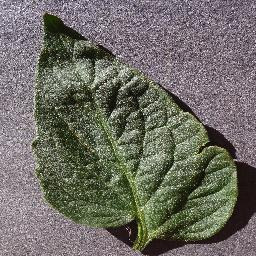

In [ ]:
im = images.take(5)[2][0] #take third image
Image.fromarray(toNDArray(im), "RGB")

It is better to have images of the same dimension, so I resized them, now they have all dimension 64x64. This is the maximum dimension the images can have without rising memory issues during training.

I tried using grayscale images but the model performance degraded so I kept them in the original RGB format.

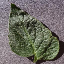

In [ ]:
tr = (ImageTransformer().setOutputCol("transformed").resize(64, 64))

small = tr.transform(images).select("transformed")
im = small.take(5)[2][0]                  #take third image
Image.fromarray(toNDArray(im), "RGB")

In [ ]:
small.select("transformed.origin", "transformed.height", "transformed.width", "transformed.data").show(5)

+--------------------+------+-----+--------------------+
|              origin|height|width|                data|
+--------------------+------+-----+--------------------+
|file:///content/d...|    64|   64|[65 A9 99 21 6C 4...|
|file:///content/d...|    64|   64|[5F 51 5D B3 A5 B...|
|file:///content/d...|    64|   64|[A6 98 9E A5 97 9...|
|file:///content/d...|    64|   64|[93 84 88 99 8A 8...|
|file:///content/d...|    64|   64|[6D 65 70 8C 84 8...|
+--------------------+------+-----+--------------------+
only showing top 5 rows



With SynapseML images could be unrolled into the dense 1D vectors instead of keeping them in the original binary format.

Furthermore in this cell a regex expression is used to select from the origin field the name of each directory that contains the images.

In [ ]:
unroller = UnrollImage().setInputCol("transformed").setOutputCol("unrolled")

unrolled = unroller.transform(small)

df = unrolled.select("transformed.origin", "transformed.height", "transformed.width", "unrolled").withColumn("origin",regexp_replace(col("origin"), "/", " ")).withColumn("origin",regexp_extract(col("origin"), r"(?<=\bdataset_combined_logical\s)(\w+)", 1))
df.show(5)

print("The number of classes is {:d}.".format(df.select("origin").distinct().count()))

+----------------+------+-----+--------------------+
|          origin|height|width|            unrolled|
+----------------+------+-----+--------------------+
|Cherry___healthy|    64|   64|[101.0,33.0,1.0,3...|
|Tomato___healthy|    64|   64|[95.0,179.0,104.0...|
|Tomato___healthy|    64|   64|[166.0,165.0,166....|
|Tomato___healthy|    64|   64|[147.0,153.0,156....|
|Tomato___healthy|    64|   64|[109.0,140.0,125....|
+----------------+------+-----+--------------------+
only showing top 5 rows

The number of classes is 30.


In Machine Learning, in particular working with images, scaling every image to the same range (typically the range [0,1]) will make images contributes more evenly to the total loss. Without scaling, the high pixel range images will have a large say to determine how to update weights. What we do when we scaled down images before feeding it into a model is in order to reduce the number of parameters. When the number of parameters is high, we tend to increase the requirement of computation power. In general scaling of the data makes it easy for a model to learn and understand the problem.


The original images are in the RGB format so the pixel value is in the range 0-255. Such values would be too high for our models to process, so we target values between 0 and 1 instead by scaling with a 1/255. factor.
Here I'm using a Spark UDF (User Defined Function) to apply the scaling factor to each pixel of each image.

In [ ]:
from synapse.ml .stages.UDFTransformer import UDFTransformer
import pyspark.sql.functions as F
from pyspark.ml.linalg import VectorUDT

scaler = F.udf(lambda x: (x/255),VectorUDT())

scaler_udf = UDFTransformer().setInputCol("unrolled").setOutputCol("features").setUDF(scaler)
df = scaler_udf.transform(df)
df.show(5)

+----------------+------+-----+--------------------+--------------------+
|          origin|height|width|            unrolled|            features|
+----------------+------+-----+--------------------+--------------------+
|Cherry___healthy|    64|   64|[101.0,33.0,1.0,3...|[0.39607843137254...|
|Tomato___healthy|    64|   64|[95.0,179.0,104.0...|[0.37254901960784...|
|Tomato___healthy|    64|   64|[166.0,165.0,166....|[0.65098039215686...|
|Tomato___healthy|    64|   64|[147.0,153.0,156....|[0.57647058823529...|
|Tomato___healthy|    64|   64|[109.0,140.0,125....|[0.42745098039215...|
+----------------+------+-----+--------------------+--------------------+
only showing top 5 rows



Let's suspend for a second the data preprocessing and let's focus on data exploration. A very important thing to check is if the dataset is balanced or not. The problem with training a model with an imbalanced dataset is that the model will be biased towards the majority class (or classes) only. To better visualize the distribution of the samples, I decided to plot a histogram in which is shown how many instances compose each of the 34 classes.

In the DataFrame *count* there are two columns:

- label name
- count of samples with that label

This information is then put respectively on the x and y axes of the histogram.

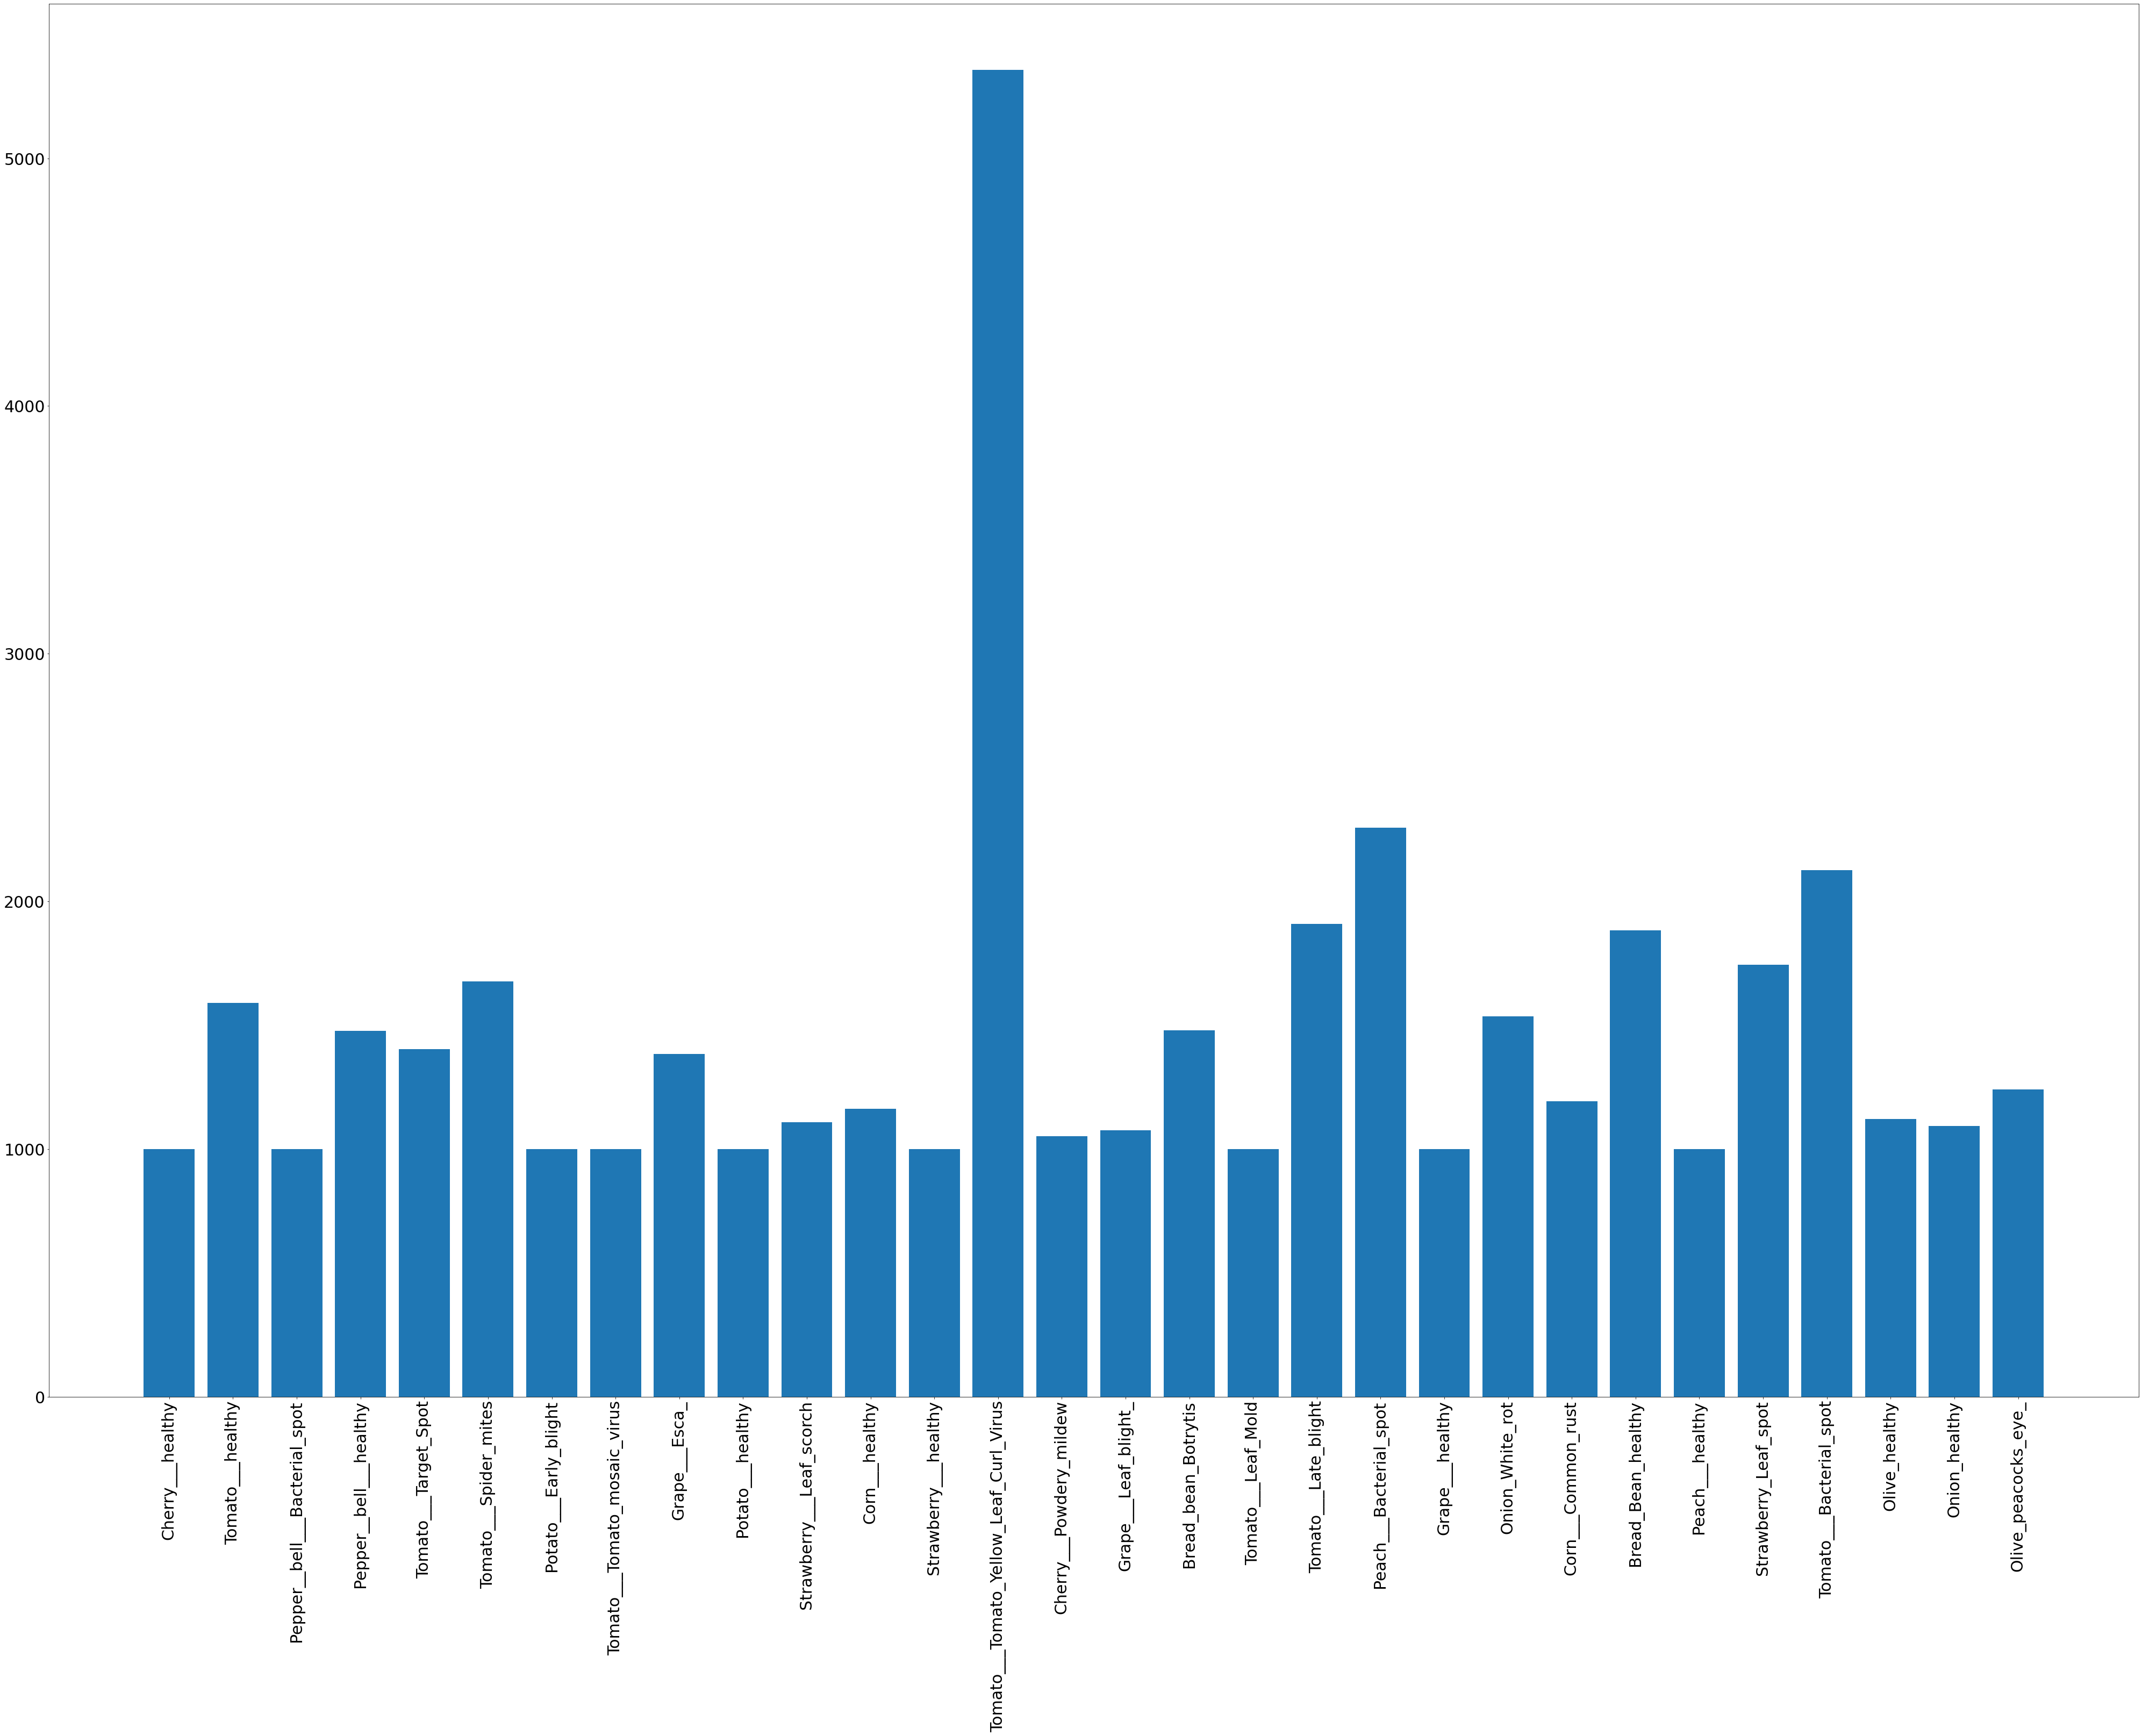

In [ ]:
count = df.groupby(["origin"]).count()

n_per_class = count.select(f.collect_list('count')).first()[0]
classes =  count.select(f.collect_list('origin')).first()[0]

fig = plt.figure()
axes = fig.add_axes([9,9,9,9])

plt.xticks(ticks=range(len(n_per_class)), labels=classes, rotation=90)
axes.tick_params(axis='both', which='major', labelsize=30)
axes.bar(classes, n_per_class)

plt.show()

As can be noticed there is a class that contains way more instances than the others. Later we will try to fix this problem.

# **4. Label encoding**

Many models are designed to operate with numerical inputs only. This is the case of the models that I am going to train. The feature "origin" contains the name of the folder from which the data comes from (so in the structure of this project it represents the name, the label of the class). It is a categorical feature. To transform _categorical_ features into _numerical_ ones we proceed as follows.
We setup a pipeline which is composed of the following steps:
- [StringIndexer](https://spark.apache.org/docs/latest/ml-features#stringindexer): encodes a string column of labels to a column of label indices. The indices are in [0, numLabels), and in my case I chose to order them in ascending alphabetical order.
- [OneHotEncoder](https://spark.apache.org/docs/latest/ml-features#onehotencoder): maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values.



In [ ]:
#implemention of the pipeline for transforming categorical features into numerical ones

indexer = StringIndexer(inputCol="origin", outputCol="label_indexed", stringOrderType="alphabetAsc")
encoder = OneHotEncoder(inputCols=["label_indexed"], outputCols=["label_vec"], dropLast=False)

pipeline = Pipeline(stages=[indexer, encoder])
features = pipeline.fit(df)
df = features.transform(df)

df = df.select("features", "origin", "label_indexed","label_vec")
df = df.withColumnRenamed("label_indexed", "label")
df.show(5)

+--------------------+----------------+-----+---------------+
|            features|          origin|label|      label_vec|
+--------------------+----------------+-----+---------------+
|[0.39607843137254...|Cherry___healthy|  3.0| (30,[3],[1.0])|
|[0.37254901960784...|Tomato___healthy| 29.0|(30,[29],[1.0])|
|[0.65098039215686...|Tomato___healthy| 29.0|(30,[29],[1.0])|
|[0.57647058823529...|Tomato___healthy| 29.0|(30,[29],[1.0])|
|[0.42745098039215...|Tomato___healthy| 29.0|(30,[29],[1.0])|
+--------------------+----------------+-----+---------------+
only showing top 5 rows



In [ ]:
dist = df.select("origin", "label")
dist = dist.distinct()
dist.sort("label").show(34)

+--------------------+-----+
|              origin|label|
+--------------------+-----+
|  Bread_Bean_healthy|  0.0|
| Bread_bean_Botrytis|  1.0|
|Cherry___Powdery_...|  2.0|
|    Cherry___healthy|  3.0|
|  Corn___Common_rust|  4.0|
|      Corn___healthy|  5.0|
|       Grape___Esca_|  6.0|
|Grape___Leaf_blight_|  7.0|
|     Grape___healthy|  8.0|
|       Olive_healthy|  9.0|
| Olive_peacocks_eye_| 10.0|
|     Onion_White_rot| 11.0|
|       Onion_healthy| 12.0|
|Peach___Bacterial...| 13.0|
|     Peach___healthy| 14.0|
|Pepper__bell___Ba...| 15.0|
|Pepper__bell___he...| 16.0|
|Potato___Early_bl...| 17.0|
|    Potato___healthy| 18.0|
|Strawberry_Leaf_spot| 19.0|
|Strawberry___Leaf...| 20.0|
|Strawberry___healthy| 21.0|
|Tomato___Bacteria...| 22.0|
|Tomato___Late_blight| 23.0|
|  Tomato___Leaf_Mold| 24.0|
|Tomato___Spider_m...| 25.0|
|Tomato___Target_Spot| 26.0|
|Tomato___Tomato_Y...| 27.0|
|Tomato___Tomato_m...| 28.0|
|    Tomato___healthy| 29.0|
+--------------------+-----+



# **5. Class Imbalance**

As noted before, there are some classes that have way more instances than the rest of the dataset. 



To solve this problem at first I tried to use an undersampling technique but it degraded my model performance. Reducing the overall size of the training dataset, can lead to a decrease in the model's ability to generalize to new data. The oversampling approaches like SMOTE could not be used because of the limited memory resources available on Google Colab, creating new instances and increasing the dataset size would have lead the training to crash. 

So the approach I chose to use is training using a weighted loss function. Using a weighted loss functions helps to adjusts the importance of each sample based on its class. Higher weights are assigned to the minority classes, so that the model pays more attention to those examples and tries to classify them correctly. This helps to balance the impact of each class on the overall loss function and allows the model to better generalize to the minority classes.

In [ ]:
count_labels = df.groupby(["label"]).count()
count_labels = count_labels.sort("label")
count_labels.show(34)

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 1884|
|  1.0| 1479|
|  2.0| 1052|
|  3.0| 1000|
|  4.0| 1192|
|  5.0| 1162|
|  6.0| 1383|
|  7.0| 1076|
|  8.0| 1000|
|  9.0| 1121|
| 10.0| 1241|
| 11.0| 1535|
| 12.0| 1094|
| 13.0| 2297|
| 14.0| 1000|
| 15.0| 1000|
| 16.0| 1477|
| 17.0| 1000|
| 18.0| 1000|
| 19.0| 1744|
| 20.0| 1109|
| 21.0| 1000|
| 22.0| 2127|
| 23.0| 1909|
| 24.0| 1000|
| 25.0| 1676|
| 26.0| 1404|
| 27.0| 5357|
| 28.0| 1000|
| 29.0| 1591|
+-----+-----+



There are several ways to compute class weights in a dataset with class imbalance but I chose to use inverse frequency weighting: this method weights each class based on the inverse of its frequency in the dataset.

In [ ]:
majority_df = count_labels.filter("count > 2500")  #The majority classes are selected
majority_classes = majority_df.select("count").collect()

total_number_of_examples_in_majority_classes = 0 #the number of instances of the majority classes is summed
for row in majority_classes:
    count_examples_majority_classes = row['count']
    total_number_of_examples_in_majority_classes += count_examples_majority_classes

In [ ]:
number_of_examples_in_each_class = count_labels.select("count").collect() 

count_values_classes = [] #the number of instances for each class are collect in a list to semplify the calculation of the weights
for row in number_of_examples_in_each_class:
    count_of_examples = row['count']
    count_values_classes.append(count_of_examples)

The map function is applying the lambda function to each element in the *count_values_classes* list. The lambda function divides the total number of examples in the majority classes by the number of examples in a particular class (x). This results in a weight for each class, with higher weights assigned to classes with fewer examples.

For example, if the total number of examples in the majority classes is 1000 and the *count_values_classes* list is [100, 50, 200], the resulting class weights would be [10, 20, 5]. This means that the class with 100 examples would have a weight of 10, the class with 50 examples would have a weight of 20, and the class with 200 examples would have a weight of 5.

This weighting scheme gives more importance to the minority classes, as they have higher weights, and less importance to the majority classes, as they have lower weights.

In [ ]:
class_weights = map(lambda x: total_number_of_examples_in_majority_classes / x, count_values_classes)

In [ ]:
class_weights = list(class_weights)
print(class_weights)

[2.8434182590233545, 3.6220419202163625, 5.092205323193916, 5.357, 4.494127516778524, 4.610154905335628, 3.873463485177151, 4.978624535315985, 5.357, 4.778768956289028, 4.316680096696213, 3.489902280130293, 4.896709323583181, 2.332172398781019, 5.357, 5.357, 3.626946513202437, 5.357, 5.357, 3.0716743119266057, 4.830477908025248, 5.357, 2.5185707569346496, 2.8061812467260348, 5.357, 3.1963007159904535, 3.8155270655270654, 1.0, 5.357, 3.3670647391577626]


Normalizing class weights can be helpful because it ensures that the sum of all weights is equal to 1. This can make it easier to compare the relative importance of each class and to understand how much weight the model is assigning to each class.

In addition, normalizing class weights can help to prevent numerical instability and improve the stability of the model. I tried to train the Convolutional Neural Network with not normalized weights but this led to large gradients and unstable training. 

In [ ]:
normalized_weights = normalize([class_weights], norm='l2')
normalized_weights = normalized_weights.squeeze()
print(normalized_weights)

[0.11941524 0.15211515 0.21385771 0.22497831 0.18874019 0.193613
 0.16267412 0.20908765 0.22497831 0.2006943  0.18128792 0.14656567
 0.20564745 0.09794441 0.22497831 0.22497831 0.15232113 0.22497831
 0.22497831 0.12900132 0.20286592 0.22497831 0.10577259 0.11785139
 0.22497831 0.13423527 0.16024096 0.04199707 0.22497831 0.14140686]


# **6. Dataset splitting**

Before starting the training of the models, we will randomly split our original dataset into 2 portions:

- training set (accounting for 80% of the total number of instances);
- test set (accounting for the remaining 20% of instances)

In [ ]:
train_df, test_df  = df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [ ]:
spark.stop()
spark.catalog.clearCache()

# **7. Convolutional Neural Network**

A convolutional neural network, or CNN, is a supervised deep learning neural network designed for processing structured arrays of data such as images. Convolutional neural networks are widely used in computer vision and have become the state of the art for many visual applications such as image classification.
CNNs are very good at picking up on patterns in the input image, such as lines, gradients, circles, or even eyes and faces. It is this property that makes convolutional neural networks so powerful for computer vision.

Other important properties of CNNs are:
- Translation invariance: in essence, it is the ability to ignore positional shifts of the target in the image. A cat is still a cat regardless of whether it appears in the top half or the bottom half of the image.
- Translation equivariance: for a convolutional neural network the position of the object in the image should not be fixed in order for it to be detected by the CNN. This means that a cat is still recognized as a cat even though, for example we change its color and then change its position. The same happens if we first shift its position and then its color. Summarizing, it simply means that if the input changes, the output also changes.

Unfortunately PySpark does not provide native tools to implement deep neural networks. Horovod allows to train DNNs with PySpark and directly from the DataFrame data structure.

Each time I am going to train a new model, I will close the previous Spark session to free up all the space in RAM memory in that moment. The dataset uploaded in these following cells has been constructed with the same methodology described above, following every step. To speed up the model training, all the previous step can be skipped and start directly from here.

In [ ]:
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1lJHdnAeU-NxSGg_XJB8MyxeZ-dRMM-Pk
!unzip -u /content/train.parquet.zip -d /content

!gdown 1vg2FaXtPZAsWxWCqDCr0QoiqXeTntNL9
!unzip -u /content/test.parquet.zip -d /content

!gdown 1Ikhcc59x-khXpI1WLqc5gt74E3iCIS1x

Output streaming troncato alle ultime 5000 righe.
 extracting: /content/train.parquet/.part-00502-e6638256-debf-49e2-a290-4474e31399bc-c000.snappy.parquet.crc  
 extracting: /content/train.parquet/.part-00503-e6638256-debf-49e2-a290-4474e31399bc-c000.snappy.parquet.crc  
 extracting: /content/train.parquet/.part-00504-e6638256-debf-49e2-a290-4474e31399bc-c000.snappy.parquet.crc  
 extracting: /content/train.parquet/.part-00505-e6638256-debf-49e2-a290-4474e31399bc-c000.snappy.parquet.crc  
 extracting: /content/train.parquet/.part-00506-e6638256-debf-49e2-a290-4474e31399bc-c000.snappy.parquet.crc  
 extracting: /content/train.parquet/.part-00507-e6638256-debf-49e2-a290-4474e31399bc-c000.snappy.parquet.crc  
 extracting: /content/train.parquet/.part-00508-e6638256-debf-49e2-a290-4474e31399bc-c000.snappy.parquet.crc  
 extracting: /content/train.parquet/.part-00509-e6638256-debf-49e2-a290-4474e31399bc-c000.snappy.parquet.crc  
 extracting: /content/train.parquet/.part-00510-e6638256-debf-

In [ ]:
weights = np.load('weights.npy') 
train_df=spark.read.parquet("/content/train.parquet")
test_df=spark.read.parquet("/content/test.parquet")

In the following cell all the Horovod, Tensorflow and PySpark needed libraries are imported. 

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.optimizers import Adam
import keras.backend as K
from keras.utils.vis_utils import plot_model  

import horovod.spark.keras as hvd
from horovod.spark.common.store import Store

import pyspark.sql.types as T
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import ConfusionMatrixDisplay

nb_classes=30

This is my custom implementation of the weighted categorical cross-entropy loss function. 

The function takes two inputs, *y_true* and *y_pred*, which represent the true class labels and the predicted class probabilities respectively.

- The first line normalizes the predicted class probabilities so that they sum up to 1. This is done by dividing each element in *y_pred* by the sum of all elements along the last axis.
- The second line clips the predicted class probabilities to a minimum value of K.epsilon() and a maximum value of 1 - K.epsilon(). This is done to avoid numerical instability during the computation of the loss.
- The third line calculates the loss by multiplying the true class labels with the log of the predicted class probabilities, and then taking the product with the weights.
- The fourth line takes the negative sum of the loss along the last axis.

Finally, the function returns the loss, which represents how well the predicted class probabilities match the true class labels.

In [ ]:
def custom_categorical_crossentropy(y_true, y_pred): 
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

As explained before Horovod allows to train in a distributed manner a network implemented with Keras.

It is a very simple network with just 1,629,538 parameters. I decided to use this kind of architecture because the bigger the number of parameters, the higher are complexity and resources necessary for the training. During the training, the RAM often reaches almost its limit, so I was very restricted from that point of view. In a situation in which my resources were very restricted I opted for trying to keep the images as big as possible and in RGB since I noted that these two aspects were the determinant factors of my prediction, instead of using smaller images with a more complex network. Another problem is that the other (more complex) networks I tried often led to overfitting. So this  network was the "perfect" trade-off between the various aspects I had to manage.





The network starts with the Sequential model, which is a linear stack of layers.

- The first layer is the Reshape layer, which takes the input shape of (12288,) (in the Spark DataFrames the images are stored as 1D DenseVectors) and reshapes it into a (64, 64, 3) tensor.
- Then, there are two Conv2D layers, which apply filters to the input tensor to extract features. The first Conv2D layer has 32 filters with a 3x3 kernel size, and the activation function used is ReLU (rectified linear unit).
- The MaxPooling2D layers are used to down-sample the feature maps generated by the Conv2D layers. The pool size is 2x2, meaning the maximum value of a 2x2 window will be taken for each step.
- The Dropout layer is used to prevent overfitting by randomly dropping out some neurons during training. The rate of 0.25 means that 25% of the neurons will be dropped out.
- The Flatten layer is used to flatten the output from the previous layer into a 1-dimensional array, which is then fed into two Dense layers. The first Dense layer has 128 neurons and uses ReLU as the activation function, and the second Dense layer is the output layer with the number of neurons equal to the number of classes in the problem, and uses softmax as the activation function to produce probability scores for each class.

The optimizer used to train the network is the Adam optimizer with a learning rate of 0.0001.

In [ ]:
model = Sequential(
    [
        layers.Reshape((64, 64, 3), input_shape=(12288,)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(nb_classes, activation="softmax")
    ]
)

optimizer = optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

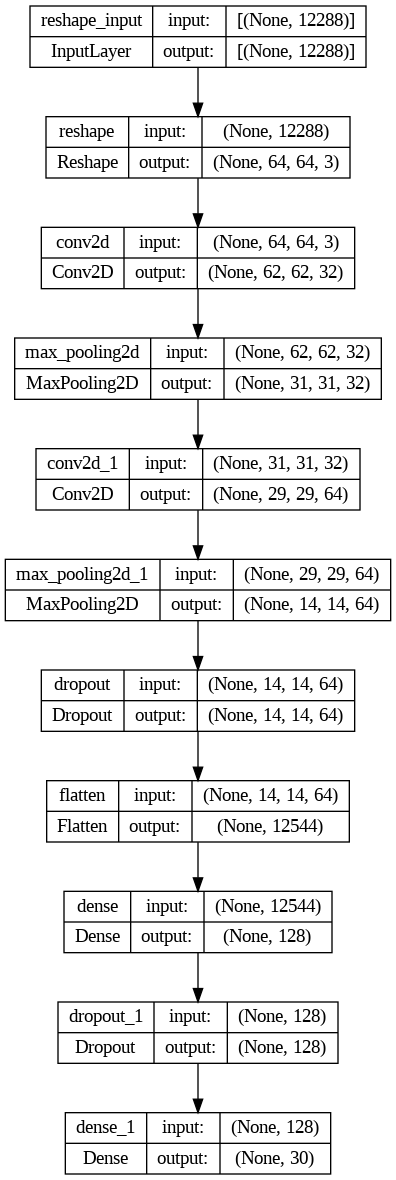

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

All the "magic" of Horovod is hold in here: Horovod Spark Estimators. They allow to train a deep neural network directly on an existing Spark DataFrame, leveraging Horovod’s ability to scale across multiple workers, without any specialized code for distributed training. 

The Estimator hides the complexity, the user only needs to provide a Keras (or PyTorch) model, and the Estimator will do the work of fitting it to the DataFrame.
After training, the Estimator returns a Transformer representation of the trained model. The model transformer can be used like any Spark ML transformer to make predictions on an input DataFrame.

Let's analyze the choices I made for some of the parameters of the KerasEstimator:
- num_proc, it was set at 2 because the number of cores available on Colab is 2;
- validation, it sets the size of the validation test, which in this case is 10% of the training data. The idea is that you train on your training data and tune your model with the results of metrics (accuracy, loss etc.) that you get from the validation set;
- batch_size, generally the larger the batch size, the quicker our model will complete each epoch during training. This is because, depending on our computational resources, our machine may be able to process much more than one single sample at a time. The trade-off, however, is that even if our machine can handle very large batches, the quality of the model may degrade as we set our batch larger and may ultimately cause the model to be unable to generalize well on data it has not seen before;
- metrics, I chose accuracy (the number of correct predictions over all the predictions made), precision (the number of correctly predicted positive instances over all the positive predictions made) and recall (the number of correctly predicted positive instances over all the actually positive existing instances);
- epochs, I stopped the training at 30 epochs because at that point the accuracy stopped increasing.

Since the loss is computed with a weighted categorical crossentropy, it requires one-hot encoded labels.

In [ ]:
store = Store.create(r"/content/experiments")

keras_estimator = hvd.KerasEstimator(
    num_proc=2,
    store=store,
    model=model,
    optimizer=optimizer,
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()],
    loss=custom_categorical_crossentropy,
    random_seed = RANDOM_SEED,
    custom_objects={'custom_categorical_crossentropy': custom_categorical_crossentropy},
    validation=0.1,
    feature_cols=['features'],
    label_cols=['label_vec'],
    batch_size=34,
    epochs=30)

In the following cell the KerasEstimator is fitted directly on the train DataFrame.

In [ ]:
keras_model = keras_estimator.fit(train_df).setOutputCols(['label_prob'])

num_partitions=20
writing dataframes
train_data_path=file:///content/experiments/intermediate_train_data.0
val_data_path=file:///content/experiments/intermediate_val_data.0
train_partitions=18
val_partitions=2


/usr/local/lib/python3.8/dist-packages/horovod/spark/common/util.py:495: FutureWarning: 'ParquetDataset.schema' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.schema' attribute instead (which will return an Arrow schema instead of a Parquet schema).
  train_data_schema = train_data.schema.to_arrow_schema()
/usr/local/lib/python3.8/dist-packages/horovod/spark/common/util.py:405: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.fragments' attribute instead.
  for piece in dataset.pieces:
/usr/local/lib/python3.8/dist-packages/horovod/spark/common/util.py:506: FutureWarning: 'ParquetDataset.schema' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_

train_rows=31561
val_rows=3511
[1,0]<stdout>:Pinning current process to the GPU.


[1,1]<stderr>:2023-02-10 23:53:55.132521: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[1,0]<stderr>:2023-02-10 23:53:55.135234: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[1,0]<stdout>:Shared lib path is pointing to: <CDLL '/usr/local/lib/python3.8/dist-packages/horovod/tensorflow/mpi_lib.cpython-38-x86_64-linux-gnu.so', handle 66a1050 at 0x7fa850ebd040>
[1,0]<stdout>:Training parameters: Epochs: 30, Scaled lr: 0.00019999999494757503, Shuffle: True, random_seed: 1
[1,0]<stdout>:Train rows: 31561, Train batch size: 34, Train_steps_per_epoch: 465
[1,0]<stdout>:Val rows: 3511, Val batch size: 34, Val_steps_per_epoch: 52
[1,0]<stdout>:Checkpoint file: file:///content/experiments/runs/keras_1676073226, Logs dir: file:///content/experiments/runs/keras_1676073226/logs
[1,0]<stdout>:
[1,0]<stdout>:data_module: <class 'horovod.spark.keras.datamodule.PetastormDataModule'>


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem = pyarrow.localfs
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
[1,0]<stderr>:  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
[1,0]<stderr>:  if not dataset.common_metadata:
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/reader.py:420: FutureWarning: Specifying the 'metadata_nthreads' argume

[1,0]<stdout>:Epoch 1/30


[1,0]<stderr>:WARNING:tensorflow:AutoGraph could not transform <function custom_categorical_crossentropy at 0x7fa8bd4f6d30> and will run it as-is.
[1,0]<stderr>:Cause: Unable to locate the source code of <function custom_categorical_crossentropy at 0x7fa8bd4f6d30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
[1,0]<stderr>:To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[1,0]<stderr>:WARNING:tensorflow:AutoGraph could not transform <function custom_categorical_crossentropy at 0x7fa8bd4f6d30> and will run it as-is.
[1,0]<stderr>:Cause: Unable to locate the source code of <function custom_categorical_crossentropy at 0x7fa8bd4f6d30>. Note that functions

[1,1]<stderr>:2023-02-10 23:54:52.969404: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 231407616 exceeds 10% of free system memory.


[1,0]<stderr>:2023-02-10 23:54:59.706694: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 206635008 exceeds 10% of free system memory.


[1,1]<stderr>:2023-02-10 23:55:28.425058: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 206045184 exceeds 10% of free system memory.


[1,1]<stderr>:2023-02-10 23:56:30.483177: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 216465408 exceeds 10% of free system memory.


[1,1]<stderr>:2023-02-10 23:57:03.572126: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 218234880 exceeds 10% of free system memory.


[1,1]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,1]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 283s 576ms/step - loss: 0.4036 - accuracy: 0.2141 - precision: 0.6843 - recall: 0.0429 - val_loss: 0.2506 - val_accuracy: 0.5311 - val_precision: 0.8594 - val_recall: 0.1555
[1,0]<stdout>:Epoch 2/30


[1,1]<stderr>:2023-02-10 23:58:55.706678: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 206045184 exceeds 10% of free system memory.


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  partition_names = self._dataset.partitions.partition_names if self._dataset.partitions else set()
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:2023-02-10 23:59:56.149444: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 206635008 exceeds 10% of free system memory.


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 257s 554ms/step - loss: 0.2754 - accuracy: 0.4274 - precision: 0.7102 - recall: 0.1925 - val_loss: 0.1750 - val_accuracy: 0.6649 - val_precision: 0.8841 - val_recall: 0.3575
[1,0]<stdout>:Epoch 3/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:2023-02-11 00:04:25.457828: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 206635008 exceeds 10% of free system memory.


[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 270s 582ms/step - loss: 0.2259 - accuracy: 0.5272 - precision: 0.7552 - recall: 0.3138 - val_loss: 0.1408 - val_accuracy: 0.7059 - val_precision: 0.8862 - val_recall: 0.4729
[1,0]<stdout>:Epoch 4/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:2023-02-11 00:07:55.298075: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 206635008 exceeds 10% of free system memory.


[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 273s 589ms/step - loss: 0.1931 - accuracy: 0.5978 - precision: 0.7883 - recall: 0.4066 - val_loss: 0.1122 - val_accuracy: 0.7910 - val_precision: 0.9092 - val_recall: 0.5998
[1,0]<stdout>:Epoch 5/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:2023-02-11 00:14:33.500141: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 206635008 exceeds 10% of free system memory.


[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 283s 609ms/step - loss: 0.1737 - accuracy: 0.6329 - precision: 0.8052 - recall: 0.4683 - val_loss: 0.0945 - val_accuracy: 0.8179 - val_precision: 0.9200 - val_recall: 0.6830
[1,0]<stdout>:Epoch 6/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 274s 590ms/step - loss: 0.1554 - accuracy: 0.6713 - precision: 0.8138 - recall: 0.5243 - val_loss: 0.0839 - val_accuracy: 0.8408 - val_precision: 0.9197 - val_recall: 0.7412
[1,0]<stdout>:Epoch 7/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 277s 596ms/step - loss: 0.1461 - accuracy: 0.6878 - precision: 0.8269 - recall: 0.5550 - val_loss: 0.0755 - val_accuracy: 0.8532 - val_precision: 0.9241 - val_recall: 0.7681
[1,0]<stdout>:Epoch 8/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 279s 600ms/step - loss: 0.1371 - accuracy: 0.7082 - precision: 0.8324 - recall: 0.5864 - val_loss: 0.0725 - val_accuracy: 0.8696 - val_precision: 0.9328 - val_recall: 0.7820
[1,0]<stdout>:Epoch 9/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 272s 586ms/step - loss: 0.1307 - accuracy: 0.7160 - precision: 0.8336 - recall: 0.6009 - val_loss: 0.0688 - val_accuracy: 0.8628 - val_precision: 0.9160 - val_recall: 0.7865
[1,0]<stdout>:Epoch 10/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 266s 573ms/step - loss: 0.1213 - accuracy: 0.7403 - precision: 0.8470 - recall: 0.6343 - val_loss: 0.0652 - val_accuracy: 0.8716 - val_precision: 0.9294 - val_recall: 0.8114
[1,0]<stdout>:Epoch 11/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 262s 564ms/step - loss: 0.1166 - accuracy: 0.7457 - precision: 0.8487 - recall: 0.6450 - val_loss: 0.0595 - val_accuracy: 0.8840 - val_precision: 0.9307 - val_recall: 0.8309
[1,0]<stdout>:Epoch 12/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 270s 582ms/step - loss: 0.1118 - accuracy: 0.7568 - precision: 0.8516 - recall: 0.6617 - val_loss: 0.0600 - val_accuracy: 0.8857 - val_precision: 0.9339 - val_recall: 0.8235
[1,0]<stdout>:Epoch 13/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 266s 572ms/step - loss: 0.1075 - accuracy: 0.7645 - precision: 0.8580 - recall: 0.6775 - val_loss: 0.0573 - val_accuracy: 0.8843 - val_precision: 0.9263 - val_recall: 0.8346
[1,0]<stdout>:Epoch 14/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 270s 582ms/step - loss: 0.1042 - accuracy: 0.7707 - precision: 0.8589 - recall: 0.6886 - val_loss: 0.0553 - val_accuracy: 0.8962 - val_precision: 0.9383 - val_recall: 0.8428
[1,0]<stdout>:Epoch 15/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 272s 585ms/step - loss: 0.0989 - accuracy: 0.7823 - precision: 0.8644 - recall: 0.7004 - val_loss: 0.0510 - val_accuracy: 0.8948 - val_precision: 0.9353 - val_recall: 0.8546
[1,0]<stdout>:Epoch 16/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 272s 587ms/step - loss: 0.0966 - accuracy: 0.7826 - precision: 0.8624 - recall: 0.7076 - val_loss: 0.0495 - val_accuracy: 0.8976 - val_precision: 0.9334 - val_recall: 0.8676
[1,0]<stdout>:Epoch 17/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 265s 570ms/step - loss: 0.0932 - accuracy: 0.7936 - precision: 0.8729 - recall: 0.7217 - val_loss: 0.0477 - val_accuracy: 0.8996 - val_precision: 0.9317 - val_recall: 0.8716
[1,0]<stdout>:Epoch 18/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 267s 574ms/step - loss: 0.0900 - accuracy: 0.8001 - precision: 0.8738 - recall: 0.7303 - val_loss: 0.0467 - val_accuracy: 0.9106 - val_precision: 0.9419 - val_recall: 0.8713
[1,0]<stdout>:Epoch 19/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 258s 556ms/step - loss: 0.0889 - accuracy: 0.8025 - precision: 0.8720 - recall: 0.7335 - val_loss: 0.0447 - val_accuracy: 0.9109 - val_precision: 0.9405 - val_recall: 0.8855
[1,0]<stdout>:Epoch 20/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 262s 565ms/step - loss: 0.0857 - accuracy: 0.8098 - precision: 0.8794 - recall: 0.7429 - val_loss: 0.0428 - val_accuracy: 0.9146 - val_precision: 0.9406 - val_recall: 0.8775
[1,0]<stdout>:Epoch 21/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 257s 554ms/step - loss: 0.0829 - accuracy: 0.8112 - precision: 0.8762 - recall: 0.7503 - val_loss: 0.0433 - val_accuracy: 0.9154 - val_precision: 0.9455 - val_recall: 0.8838
[1,0]<stdout>:Epoch 22/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 274s 591ms/step - loss: 0.0797 - accuracy: 0.8207 - precision: 0.8850 - recall: 0.7621 - val_loss: 0.0426 - val_accuracy: 0.9129 - val_precision: 0.9401 - val_recall: 0.8826
[1,0]<stdout>:Epoch 23/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 270s 581ms/step - loss: 0.0794 - accuracy: 0.8223 - precision: 0.8835 - recall: 0.7632 - val_loss: 0.0403 - val_accuracy: 0.9228 - val_precision: 0.9468 - val_recall: 0.8951
[1,0]<stdout>:Epoch 24/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 270s 582ms/step - loss: 0.0787 - accuracy: 0.8222 - precision: 0.8814 - recall: 0.7667 - val_loss: 0.0391 - val_accuracy: 0.9180 - val_precision: 0.9448 - val_recall: 0.8951
[1,0]<stdout>:Epoch 25/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 259s 559ms/step - loss: 0.0740 - accuracy: 0.8341 - precision: 0.8906 - recall: 0.7798 - val_loss: 0.0406 - val_accuracy: 0.9152 - val_precision: 0.9386 - val_recall: 0.8903
[1,0]<stdout>:Epoch 26/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 271s 583ms/step - loss: 0.0735 - accuracy: 0.8340 - precision: 0.8908 - recall: 0.7818 - val_loss: 0.0394 - val_accuracy: 0.9194 - val_precision: 0.9469 - val_recall: 0.8976
[1,0]<stdout>:Epoch 27/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 270s 581ms/step - loss: 0.0718 - accuracy: 0.8350 - precision: 0.8901 - recall: 0.7847 - val_loss: 0.0368 - val_accuracy: 0.9242 - val_precision: 0.9470 - val_recall: 0.8993
[1,0]<stdout>:Epoch 28/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 268s 577ms/step - loss: 0.0695 - accuracy: 0.8416 - precision: 0.8936 - recall: 0.7925 - val_loss: 0.0355 - val_accuracy: 0.9239 - val_precision: 0.9462 - val_recall: 0.9055
[1,0]<stdout>:Epoch 29/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 267s 575ms/step - loss: 0.0693 - accuracy: 0.8417 - precision: 0.8944 - recall: 0.7952 - val_loss: 0.0342 - val_accuracy: 0.9290 - val_precision: 0.9475 - val_recall: 0.9140
[1,0]<stdout>:Epoch 30/30


[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.8/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partition

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


465/465 [==============================] - 263s 567ms/step - loss: 0.0665 - accuracy: 0.8477 - precision: 0.8958 - recall: 0.8022 - val_loss: 0.0349 - val_accuracy: 0.9242 - val_precision: 0.9435 - val_recall: 0.9061


Here we tangibly obtain the results of the training: in the column *label_prob* are collected the probability scores for each class generated by the softmax activation function of the last layer of the network.


In [ ]:
pred_df = keras_model.transform(test_df)
pred_df.show(5)

+--------------------+-----+---------------+--------------------+
|            features|label|      label_vec|          label_prob|
+--------------------+-----+---------------+--------------------+
|[0.15686274509803...|  5.0| (30,[5],[1.0])|[1.32659479277208...|
|[0.33725490196078...| 27.0|(30,[27],[1.0])|[3.49990978039393...|
|[0.36470588235294...|  1.0| (30,[1],[1.0])|[3.63736035069450...|
|[0.38823529411764...| 12.0|(30,[12],[1.0])|[7.63811897286359...|
|[0.40784313725490...| 27.0|(30,[27],[1.0])|[2.61078025864947...|
+--------------------+-----+---------------+--------------------+
only showing top 5 rows



To observe how metrics evolve during the training we can use the model history. It records training metrics for each epoch. This includes the loss and the other metrics selected (accuracy, precision, recall) not only for the train dataset but also for validation dataset.

In [ ]:
history = keras_model.getHistory()

Using Matplotlib we can better visualize the information obtained from the model history.

In [ ]:
def plot_history_loss_accuracy(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history['loss'])   
    axes[0].plot(history['val_loss'])
    axes[0].legend(['train_loss','val_loss'])

    axes[1].plot(history['accuracy'])   
    axes[1].plot(history['val_accuracy'])
    axes[1].legend(['train_accuracy','val_accuracy'])

def plot_history_precision_recall(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history['precision'])   
    axes[0].plot(history['val_precision'])
    axes[0].legend(['train_precision','val_precision'])

    axes[1].plot(history['recall'])   
    axes[1].plot(history['val_recall'])
    axes[1].legend(['train_recall','val_recall'])

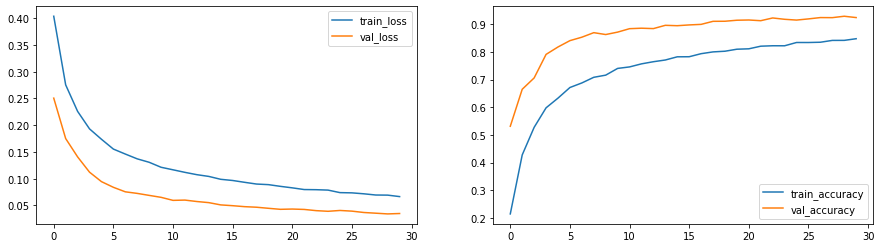

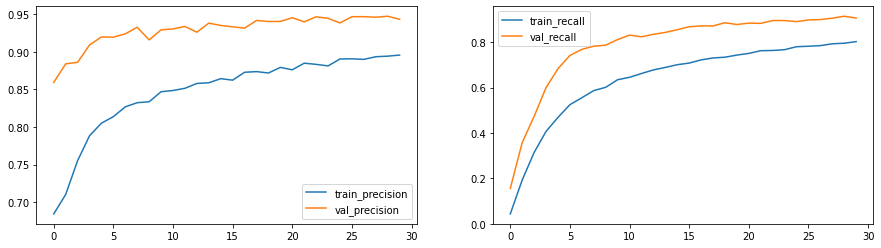

In [ ]:
plot_history_loss_accuracy(history)
plot_history_precision_recall(history)

In these 4 plots are shown respectively the evolution of loss, accuracy, precision and recall on train and validation sets. 

As can be noted the loss uniformly decreases on both sets. In the case of the other metrics they increase pretty uniformly and most importantly the model does not suffer of overfitting. A model overfits its training data when you see that the model performs well on the training data but does not perform well on the evaluation data. This is because the model is memorizing the data it has seen and is unable to generalize to unseen examples.
But as can be seen observing these plots, the train metrics are never better than the validation ones, so the model does not suffer from this problem.

These the values of accuracy, precision, recall on the test set. Here I computed also the f1 score. The goal of the F1 score is to combine the precision and recall metrics into a single metric. At the same time, the F1 score has been designed to work well on imbalanced data. The F1 score is defined as the harmonic mean of precision and recall. 

In [ ]:
argmax = udf(lambda v: float(np.argmax(v)), returnType=T.DoubleType())
pred_df = pred_df.withColumn('label_pred', argmax(pred_df.label_prob))
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol='label_pred', labelCol='label', metricName='accuracy')
evaluator_precision =  MulticlassClassificationEvaluator(predictionCol='label_pred', labelCol='label', metricName='weightedPrecision')
evaluator_recall =  MulticlassClassificationEvaluator(predictionCol='label_pred', labelCol='label', metricName='weightedRecall')
evaluator_f1 =  MulticlassClassificationEvaluator(predictionCol='label_pred', labelCol='label', metricName='f1')

print('Test accuracy:', evaluator_accuracy.evaluate(pred_df))
print('Test precision:', evaluator_precision.evaluate(pred_df))
print('Test recall:', evaluator_recall.evaluate(pred_df))
print('Test f1 score:', evaluator_f1.evaluate(pred_df))

Test accuracy: 0.9144602851323829
Test precision: 0.9169013131991719
Test recall: 0.9144602851323829
Test f1 score: 0.9147206197084351


Another technique used to evaluate the performance of a model is the confusion matrix, which counts the well classified and the miss classified samples with respect to the various classes. The matrix is organized with true classes on the rows and predicted classes on the columns. Each cell of the matrix represents the number of instances that are correctly (True Positives) or incorrectly (False Positives, False Negatives, True Negatives) predicted as a certain class.

In [ ]:
predictionAndLabels = pred_df.select("label_pred", "label").rdd

In [ ]:
metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


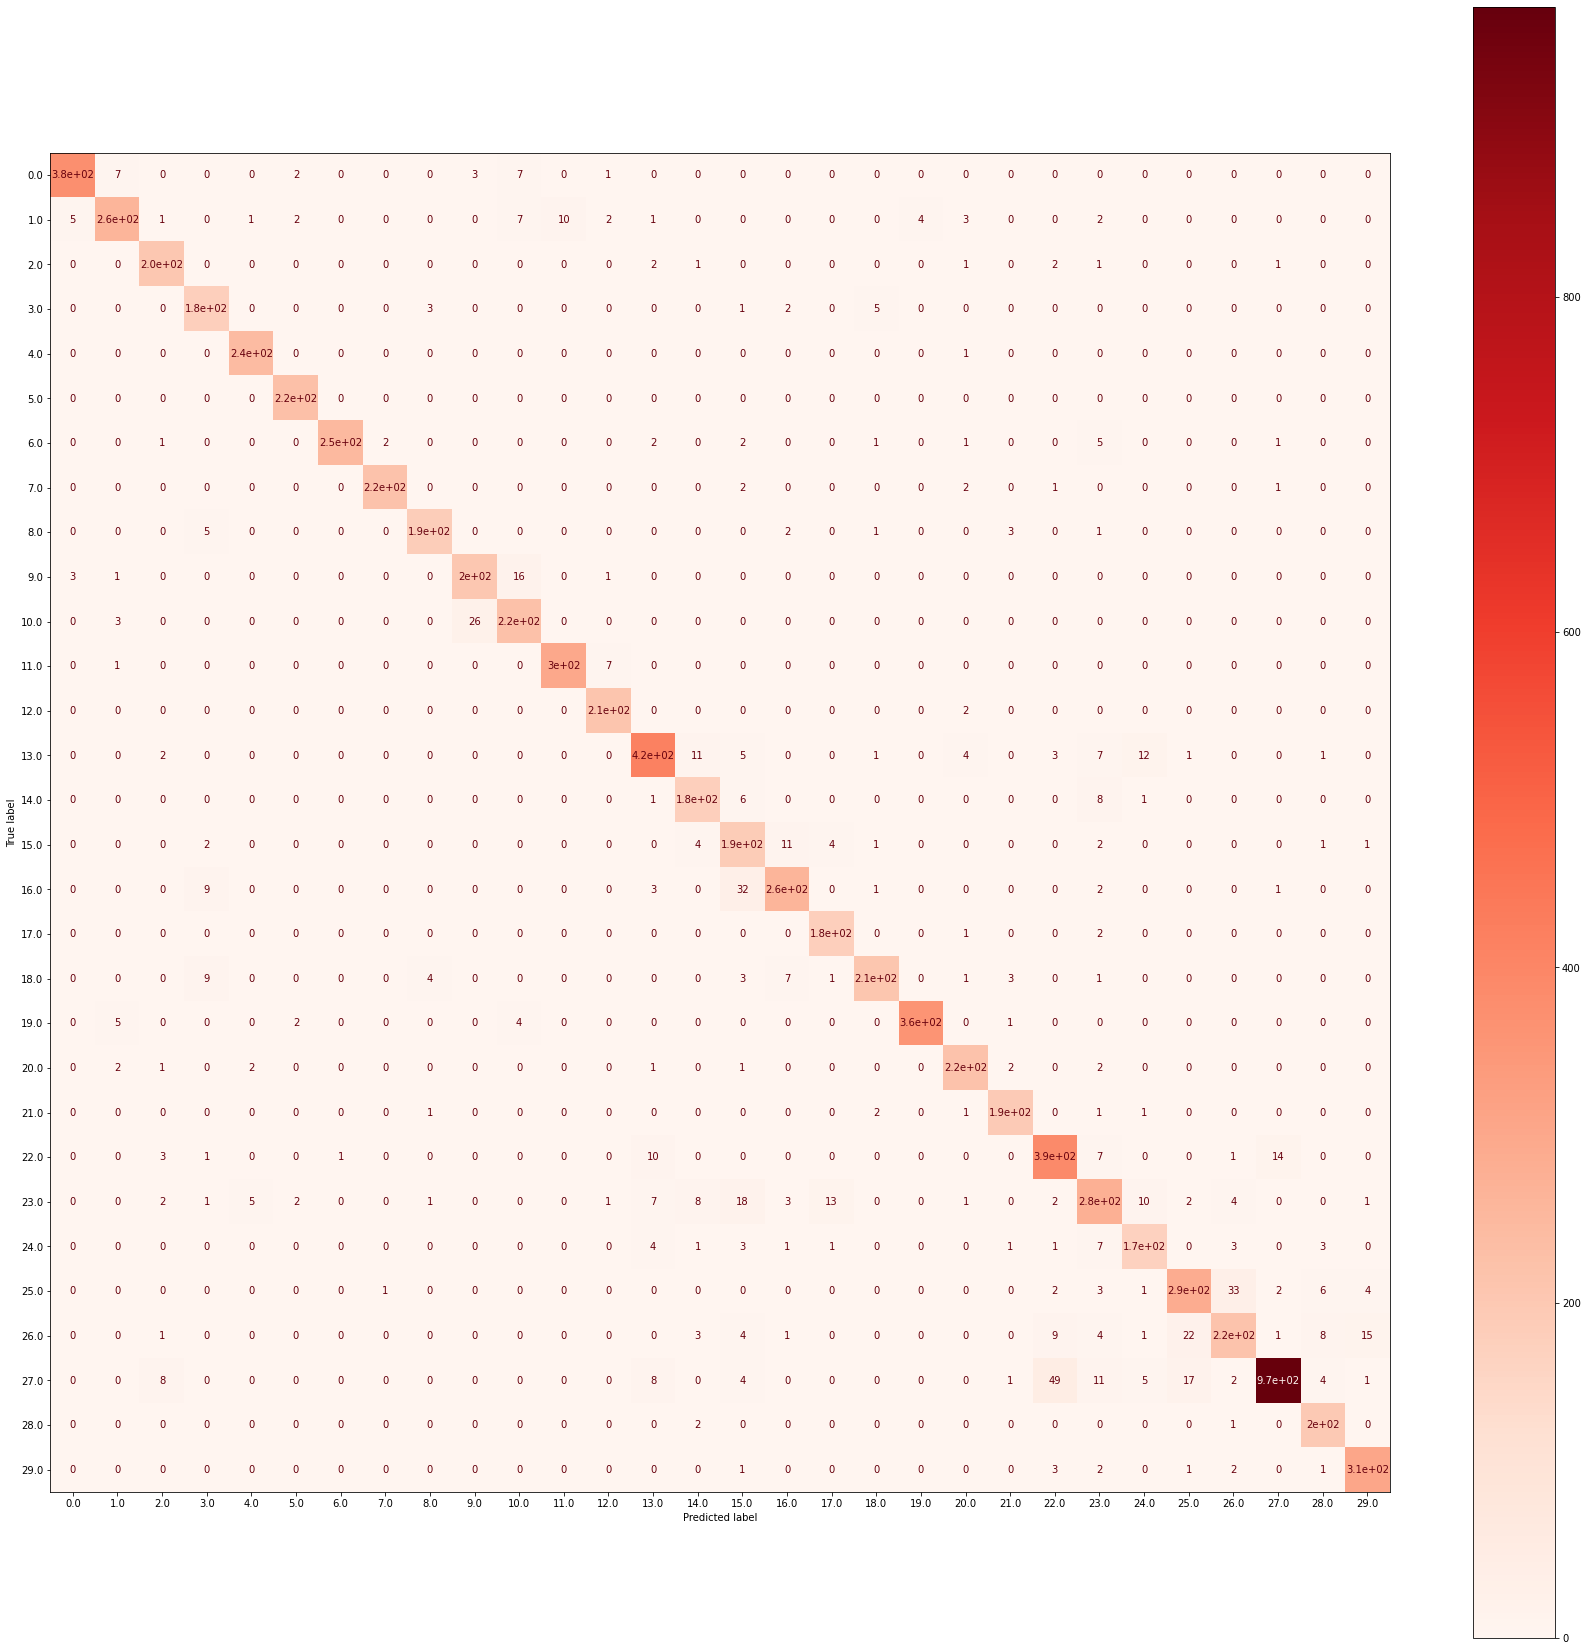

In [ ]:
label_names = np.arange(0, 30, dtype=float)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(cmap=plt.cm.Reds, ax=ax)
plt.show()

Observing the confusion matrix we can notice that the number of correct predictions (you can find them on the diagonal) is high and the number of incorrect predictions is very low for all the classes.

Talking about hyperparameter tuning my original plan was to use specific techniques like grid search or using the [Distributed Hyperparameter Search ](https://) offered by Horovod with the integration of [Ray Tune](https://docs.ray.io/en/latest/tune/). Due to the limited memory resources that was not possible so I tuned some crucial hyperparameters like batch size and learning rate doing a "manual" grid search, running every time the model with the a different configuration of these hyperparameters but keeping all the rest identical including the dataset split.
These are the results that led me to choose the "test_1" configuration:

<center><img src="https://imgur.com/xLW9mtd.png" width="750" 
     height="200"></center>

In [ ]:
spark.stop()
spark.catalog.clearCache()

# **8. Multilayer Perceptron**

Again before starting the training of the new model I close the previous Spark Session and load again the train and test datasets.

In [ ]:
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

In [ ]:
train_df = spark.read.parquet("/content/train.parquet")
test_df = spark.read.parquet("/content/test.parquet")

In [ ]:
train_df = train_df.select("features", "label")
test_df = test_df.select("features", "label")

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

A Multilayer Perceptron (MLP) is a type of artificial neural network that is composed of multiple layers of interconnected artificial neurons, which are the basic processing units of a neural network.

MLP networks consist of an input layer, one or more hidden layers, and an output layer. Each layer is made up of neurons that receive inputs, perform a dot product and bias addition, and then apply an activation function to produce an output.

Here is how a MLP works:
- Input layer: the input layer neurons receive the input features, which are processed and then passed to the next layer.
- Hidden layer: the hidden layer neurons receive inputs from the input layer neurons, perform computations using activation functions, and then pass their output to the next layer. There can be one or more hidden layers, and their number and size determine the representational capacity of the network.
- Output layer: the output layer neurons receive inputs from the hidden layer neurons and produce the final output. The number of output layer neurons depends on the number of classes in the problem.

MLP is natively supported by PySpark. In its implementation each layer has sigmoid activation function, output layer has softmax.

In [ ]:
layers = [12288, 100, 100, 30]

mlp = MultilayerPerceptronClassifier(layers=layers, seed=RANDOM_SEED)
mlp_model = mlp.fit(train_df)

The metrics I chose for the evaluation are the same already computed for the CNN:
- accuracy
- precision
- recall
- f1 score

They were calculated on both the train and the test set to valuate if there is overfitting.

In [ ]:
predictions_df = mlp_model.transform(test_df)

In [ ]:
evaluator_accuracy_mlp = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName = 'accuracy')
evaluator_precision_mlp =  MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall_mlp =  MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
evaluator_f1_mlp =  MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

print('Test accuracy:', evaluator_accuracy_mlp.evaluate(predictions_df))
print('Test precision:', evaluator_precision_mlp.evaluate(predictions_df))
print('Test recall:', evaluator_recall_mlp.evaluate(predictions_df))
print('Test f1 score:', evaluator_f1_mlp.evaluate(predictions_df))

Test accuracy: 0.6512785698121747
Test precision: 0.6436257741960043
Test recall: 0.6512785698121747
Test f1 score: 0.6430954356232622


In [ ]:
predictions_df_train = mlp_model.transform(train_df)

In [ ]:
print('Train accuracy:', evaluator_accuracy_mlp.evaluate(predictions_df_train))
print('Train precision:', evaluator_precision_mlp.evaluate(predictions_df_train))
print('Train recall:', evaluator_recall_mlp.evaluate(predictions_df_train))
print('Train f1 score:', evaluator_f1_mlp.evaluate(predictions_df_train))

Train accuracy: 0.6664860857664233
Train precision: 0.6590903384147315
Train recall: 0.6664860857664233
Train f1 score: 0.6584092834998826


In [ ]:
predictionAndLabels_mlp = predictions_df.select("prediction", "label").rdd

In [ ]:
cm_mlp = MulticlassMetrics(predictionAndLabels_mlp)
cm_mlp = cm_mlp.confusionMatrix().toArray()

Also in this case I computed the confusion matrix.

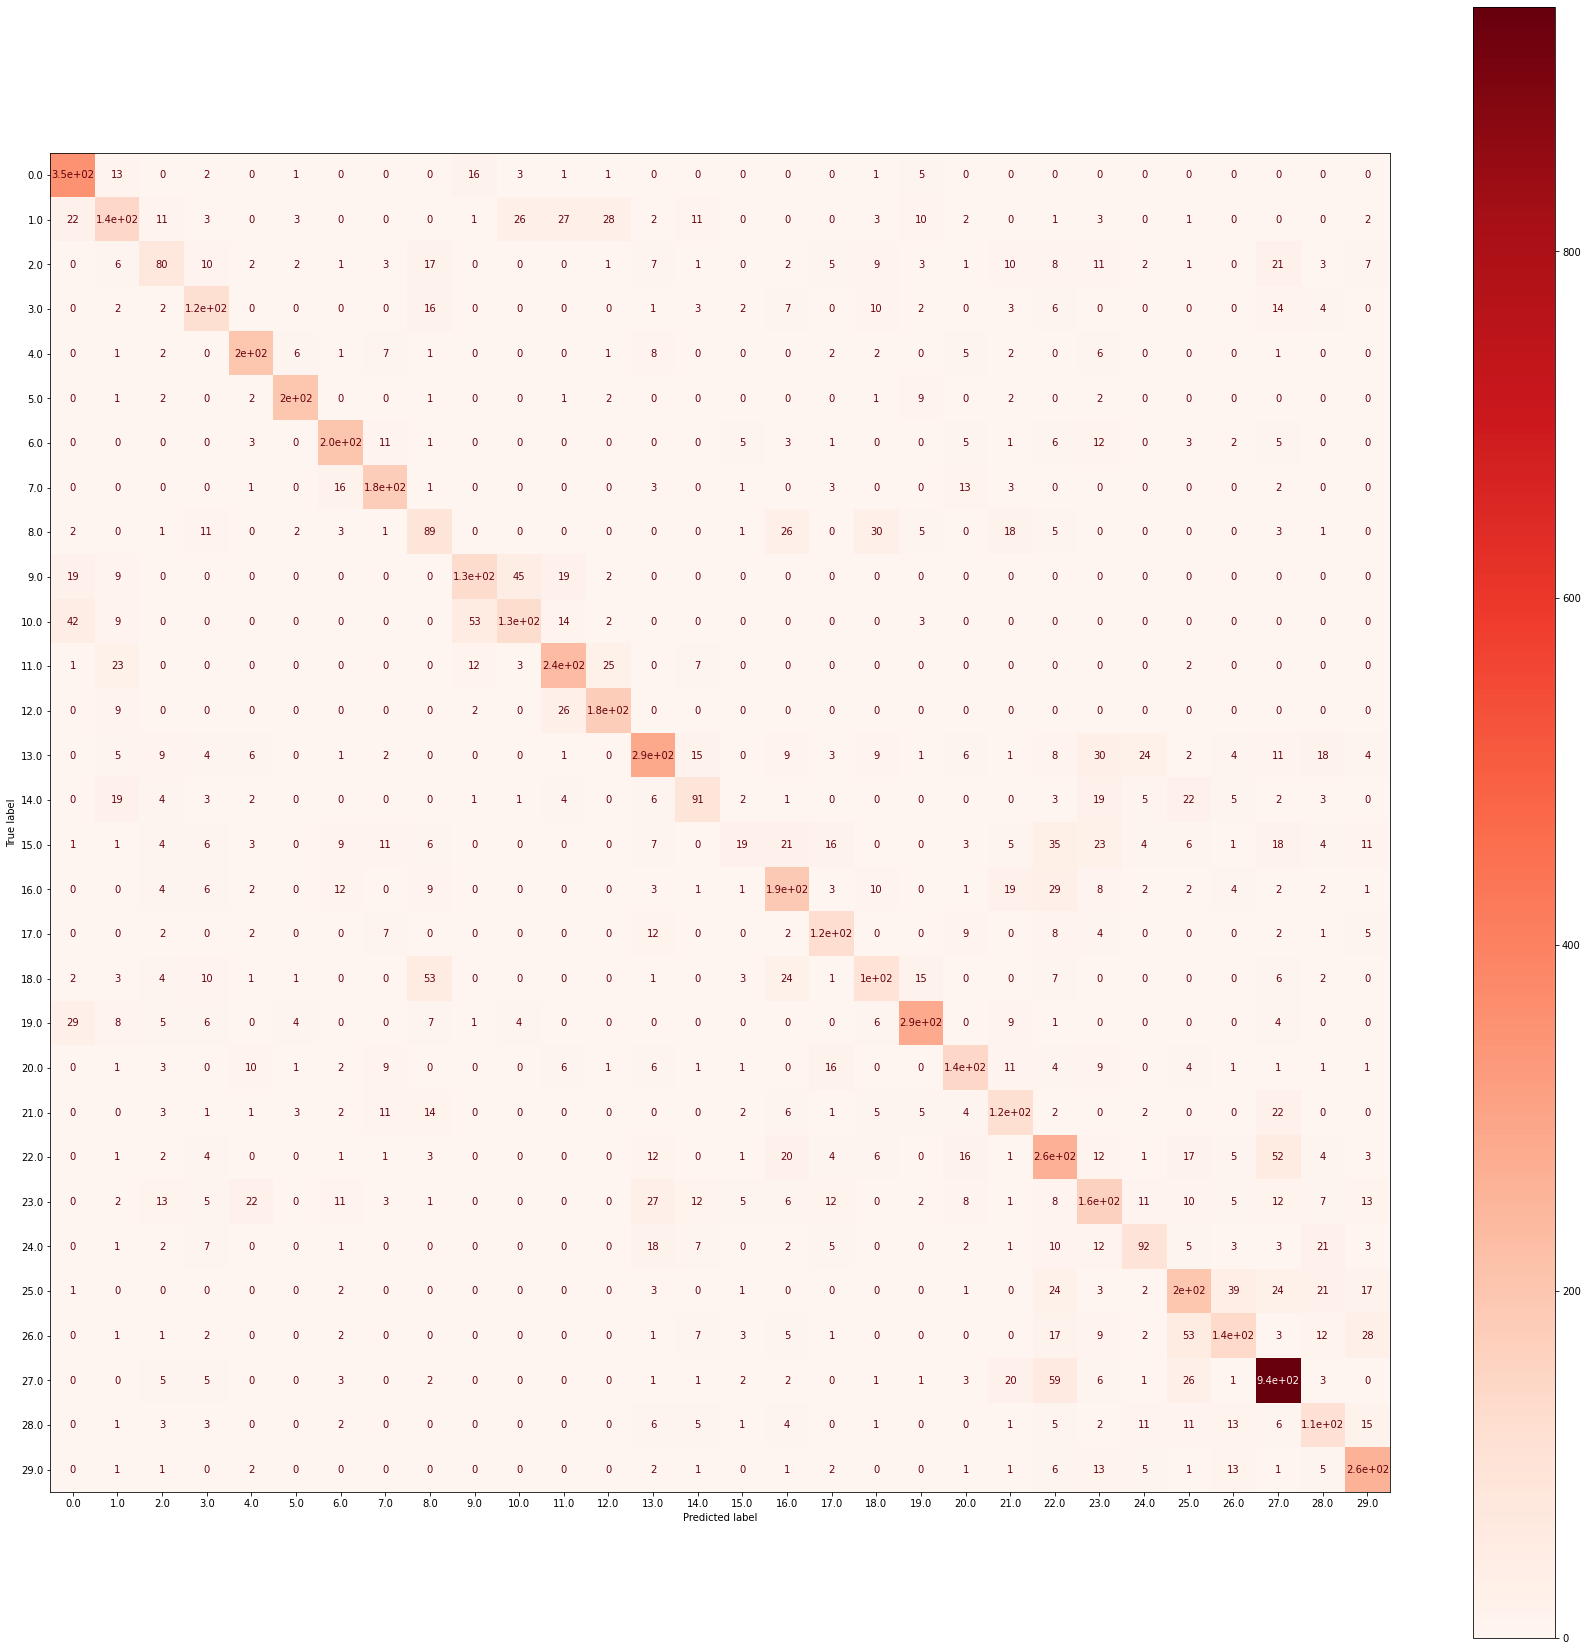

In [ ]:
label_names = np.arange(0, 30, dtype=float)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=label_names)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(cmap=plt.cm.Reds, ax=ax)
plt.show()

Observing the matrix is immediately evident that in general there are way more misclassified instances than in the confusion matrix for CNN. At the same time though an interesting phenomenon can be noticed: every class has a decrease in the number of True Positives of about 40-50 units but there are some classes (2.0, 8.0, 14.0, 18.0, 24.0 and in particular 15.0) where most of the instances are misclassified. That means that the convolutional layers in some cases are crucial to discover patterns that cannot be correctly detected with a MLP. 

I tried many different architectures (which are all summarized in the table below) and most of them lead to overfitting, especially  the ones with higher values across all the metrics. So I chose the number of nodes per layer and the other hyperparameters so that the model had the metrics for test an train as close as possible, trading-off better performance for better generalization.

<center><img src="https://imgur.com/yOowZ0G.png" width="800" 
     height="200"></center>

In [ ]:
spark.stop()
spark.catalog.clearCache()

# **9. Random Forest**

Random Forest is a machine learning algorithm used for classification and regression tasks. It is based on the idea of creating an ensemble of decision trees and combining their predictions to arrive at a final prediction. In a random forest, multiple decision trees are generated, each tree being trained on a different subset of the training data. During the prediction phase, each tree in the forest makes a prediction and the final prediction is made by taking the average or majority vote of all the trees in the forest. 

Before training the random forest I decided to use two techniques: DNN Featurization and Transfer Learning. They are two related concepts in deep learning that are often used together to solve computer vision tasks such as image classification.

DNN Featurization involves using a deep neural network to extract features from raw data, such as images, and transform them into a compact and meaningful representation that can be easily used as input to a machine learning model (in my case a random forest). The neural network is trained to extract the features in a supervised manner, where the input data is labeled and the network is optimized to predict the correct labels.

Transfer learning, on the other hand, is a technique where a pre-trained deep neural network, trained on a large dataset, is fine-tuned on a smaller dataset to solve a specific task. The idea behind transfer learning is to leverage the knowledge learned by the pre-trained network on a large dataset and transfer it to the new task, where the training data may be limited.

In the context of image classification, transfer learning can be used in combination with DNN Featurization to extract features from images. The pre-trained network can be used to extract features from the images, which can then be used as input to another machine learning model.





 

To implement these techniques I used again the SynapseML library. I will then compare the performance of the RandomForestClassifier trained with these techniques with a simple RandomForestClassifier trained without any previous feature extraction step.

Again before starting the training of the new model I close the previous Spark Session but this time I will not load again the old train and test datasets because I need images of a smaller size to train the next model.

In [ ]:
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

In [ ]:
from synapse.ml.cntk import CNTKModel
from synapse.ml.downloader import ModelDownloader
import numpy as np, os, urllib, tarfile, pickle, array
from os.path import abspath
from pyspark.sql.functions import col, udf
from synapse.ml.train import TrainClassifier
from pyspark.ml.classification import RandomForestClassifier
from synapse.ml.train import ComputeModelStatistics
import pandas as pd
from pyspark.ml.classification import RandomForestClassificationModel

I will follow the same steps seen during the dataset preprocessing:
- the data is loaded on a PySpark DataFrame;
- the images are resized to a dimension of 32 x 32;
- the binary data with which the data is read is unrolled and converted to float numbers;
- the data is scaled;
- the labels are encoder with StringIndexer.

In [ ]:
imageDir = "/content/dataset/dataset_combined_logical"

images = spark.read.image().option("recursiveFileLookup", "true").load(imageDir)

In [ ]:
resizer = (ImageTransformer().setOutputCol("transformed").resize(32, 32))
resized = resizer.transform(images).select("transformed")

unroller_resized = UnrollImage().setInputCol("transformed").setOutputCol("unrolled")
unrolled_resized = unroller_resized.transform(resized)
df = unrolled_resized.select("transformed.origin", "transformed.height", "transformed.width", "unrolled").withColumn("origin",regexp_replace(col("origin"), "/", " ")).withColumn("origin",regexp_extract(col("origin"), r"(?<=\bdataset_combined_logical\s)(\w+)", 1))
df.show(5)

+----------------+------+-----+--------------------+
|          origin|height|width|            unrolled|
+----------------+------+-----+--------------------+
|Cherry___healthy|    32|   32|[41.0,23.0,4.0,80...|
|Tomato___healthy|    32|   32|[159.0,132.0,159....|
|Tomato___healthy|    32|   32|[115.0,154.0,177....|
|Tomato___healthy|    32|   32|[164.0,174.0,168....|
|Tomato___healthy|    32|   32|[108.0,145.0,83.0...|
+----------------+------+-----+--------------------+
only showing top 5 rows



In [ ]:
scaler = F.udf(lambda x: (x/255),VectorUDT())

scaler_udf = UDFTransformer().setInputCol("unrolled").setOutputCol("features").setUDF(scaler)
df = scaler_udf.transform(df)
df.show(5)

+----------------+------+-----+--------------------+--------------------+
|          origin|height|width|            unrolled|            features|
+----------------+------+-----+--------------------+--------------------+
|Cherry___healthy|    32|   32|[41.0,23.0,4.0,80...|[0.16078431372549...|
|Tomato___healthy|    32|   32|[159.0,132.0,159....|[0.62352941176470...|
|Tomato___healthy|    32|   32|[115.0,154.0,177....|[0.45098039215686...|
|Tomato___healthy|    32|   32|[164.0,174.0,168....|[0.64313725490196...|
|Tomato___healthy|    32|   32|[108.0,145.0,83.0...|[0.42352941176470...|
+----------------+------+-----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
indexer = StringIndexer(inputCol="origin", outputCol="label_indexed", stringOrderType="alphabetAsc")

index = indexer.fit(df)
df = index.transform(df)

df = df.select("features", "origin", "label_indexed")
df = df.withColumnRenamed("label_indexed", "label")
df.show(5)

+--------------------+----------------+-----+
|            features|          origin|label|
+--------------------+----------------+-----+
|[0.16078431372549...|Cherry___healthy|  3.0|
|[0.62352941176470...|Tomato___healthy| 29.0|
|[0.45098039215686...|Tomato___healthy| 29.0|
|[0.64313725490196...|Tomato___healthy| 29.0|
|[0.42352941176470...|Tomato___healthy| 29.0|
+--------------------+----------------+-----+
only showing top 5 rows



In PySpark RandomForestClassifier has the parameter *weightCol* that allows to assign to each class an importance depending on its frequency in the dataset. This is useful to fix the imbalanced dataset.

RandomRandomForestClassifier requires the weights to be in the main DataFrame in which are stored also the information about the labels and the features.

In [ ]:
weights = np.load('weights.npy') 

In [ ]:
label_names = np.arange(0, 30, dtype=float)
weights_df = pd.DataFrame({'label': label_names, 'weights': weights})
weights_df = spark.createDataFrame(weights_df)
weights_df.show(34)

+-----+-------------------+
|label|            weights|
+-----+-------------------+
|  0.0|0.11941523708675761|
|  1.0|0.15211514987927743|
|  2.0|0.21385770596145562|
|  3.0|0.22497830667145136|
|  4.0|0.18874019016061355|
|  5.0| 0.1936130005778411|
|  6.0|0.16267411906829451|
|  7.0|0.20908764560543805|
|  8.0|0.22497830667145136|
|  9.0|0.20069429676311448|
| 10.0|0.18128791834927585|
| 11.0|0.14656567209866536|
| 12.0|0.20564744668322793|
| 13.0|0.09794440865104542|
| 14.0|0.22497830667145136|
| 15.0|0.22497830667145136|
| 16.0|0.15232112841669013|
| 17.0|0.22497830667145136|
| 18.0|0.22497830667145136|
| 19.0|0.12900132263271294|
| 20.0| 0.2028659212546901|
| 21.0|0.22497830667145136|
| 22.0| 0.1057725936396104|
| 23.0|0.11785139165607719|
| 24.0|0.22497830667145136|
| 25.0|0.13423526651041248|
| 26.0|0.16024095916770037|
| 27.0|0.04199707050055093|
| 28.0|0.22497830667145136|
| 29.0| 0.1414068552303277|
+-----+-------------------+



Weights are mapped onto the corresponding labels so that every image has a weight based its class frequency. It is done using an inner join operation combining the data from two dataframes based on a common column, called the join key (in this case the column *label*). The result of an inner join is a new dataframe that contains only the rows for which the join key is present in both dataframes.

In [ ]:
result = df.join(weights_df, on=["label"], how='inner')
result.show(5)

+-----+--------------------+------------------+-------------------+
|label|            features|            origin|            weights|
+-----+--------------------+------------------+-------------------+
|  0.0|[0.47450980392156...|Bread_Bean_healthy|0.11941523708675761|
|  0.0|[0.41960784313725...|Bread_Bean_healthy|0.11941523708675761|
|  0.0|[0.40784313725490...|Bread_Bean_healthy|0.11941523708675761|
|  0.0|[0.40784313725490...|Bread_Bean_healthy|0.11941523708675761|
|  0.0|[0.49803921568627...|Bread_Bean_healthy|0.11941523708675761|
+-----+--------------------+------------------+-------------------+
only showing top 5 rows



SynapseML allows to download and use it for the DNN featurization and transfer learning a CNTKModel. CNTK (Microsoft Cognitive Toolkit) is a deep learning framework developed by Microsoft Research. Microsoft Cognitive Toolkit describes neural networks as a series of computational steps via a directed graph. It offers a number of [pre-trained models](https://github.com/microsoft/CNTK/blob/master/PretrainedModels/Image.md) that can be used with SynapseML. Some of the most popular are AlexNet, GoogLeNet, ResNet, VGG. These networks though require very big images as input, typically of size 227x227, so given my limited resources, I had to use a way simpler pretrained network: a Convolutional Neural Network trained in the popular CIFAR-10 dataset (it requires images of size 32x32). 

In the next cells the DNN Model is downloaded and one of the inner layers is picked as feature output. Then the images are featurized.

In [ ]:
modelName = "ConvNet"
modelDir = "file:" + abspath("models")
d = ModelDownloader(spark, modelDir)
model = d.downloadByName(modelName)
print(model.layerNames)
cntkModel = CNTKModel().setInputCol("features").setOutputCol("extracted_features").setModelLocation(model.uri).setOutputNode("l6")

['z', 'l8', 'l7', 'l6', 'l5', 'l4', 'l3', 'l2', 'l1']


In [ ]:
featurizedImages = cntkModel.transform(result)

In [ ]:
featurizedImages = featurizedImages.select("extracted_features", "label", "weights")
featurizedImages.show(5)

+--------------------+-----+-------------------+
|  extracted_features|label|            weights|
+--------------------+-----+-------------------+
|[1.86534464359283...|  8.0|0.22497830667145136|
|[1.86446774005889...|  8.0|0.22497830667145136|
|[1.86745715141296...|  8.0|0.22497830667145136|
|[1.8625568151474,...|  8.0|0.22497830667145136|
|[1.86557841300964...|  8.0|0.22497830667145136|
+--------------------+-----+-------------------+
only showing top 5 rows



Now the featurized images are used to train a RandomForestClassifier. 

In [ ]:
train,test = featurizedImages.randomSplit([0.8,0.2], seed=RANDOM_SEED)

model = TrainClassifier(model=RandomForestClassifier(weightCol="weights", seed=RANDOM_SEED,  maxDepth=3, numTrees=50),labelCol="label").fit(train)

The performance of the model is evaluated based on the accuracy, precision, recall, f1 score and confusion matrix metrics.

In [ ]:
predictions_test = model.transform(test)
metrics_test = ComputeModelStatistics(evaluationMetric="all").transform(predictions_test)
metrics_test.select("accuracy", "precision", "recall").show()

+------------------+------------------+------------------+
|          accuracy|         precision|            recall|
+------------------+------------------+------------------+
|0.5381713271193964|0.5381713271193964|0.5381713271193964|
+------------------+------------------+------------------+



In [ ]:
precision_test = metrics_test.select('precision').first()[0]
recall_test = metrics_test.select('precision').first()[0]

In [ ]:
f1_test = (2 * precision_test * recall_test) / (precision_test + recall_test)
f1_test

0.5381713271193964

In [ ]:
predictions_train = model.transform(train)
metrics_train = ComputeModelStatistics(evaluationMetric="all").transform(predictions_train)
metrics_train.select("accuracy", "precision", "recall").show()

+------------------+------------------+------------------+
|          accuracy|         precision|            recall|
+------------------+------------------+------------------+
|0.5464496532752593|0.5464496532752593|0.5464496532752593|
+------------------+------------------+------------------+



In [ ]:
precision_train = metrics_train.select('precision').first()[0]
recall_train = metrics_train.select('precision').first()[0]

In [ ]:
f1_train = (2 * precision_train * recall_train) / (precision_train + recall_train)
f1_train

0.5464496532752593

In [ ]:
predictionAndLabels_rf = predictions_test.select("prediction", "label").rdd

In [ ]:
cm_rf = MulticlassMetrics(predictionAndLabels_rf)
cm_rf = cm_rf.confusionMatrix().toArray()

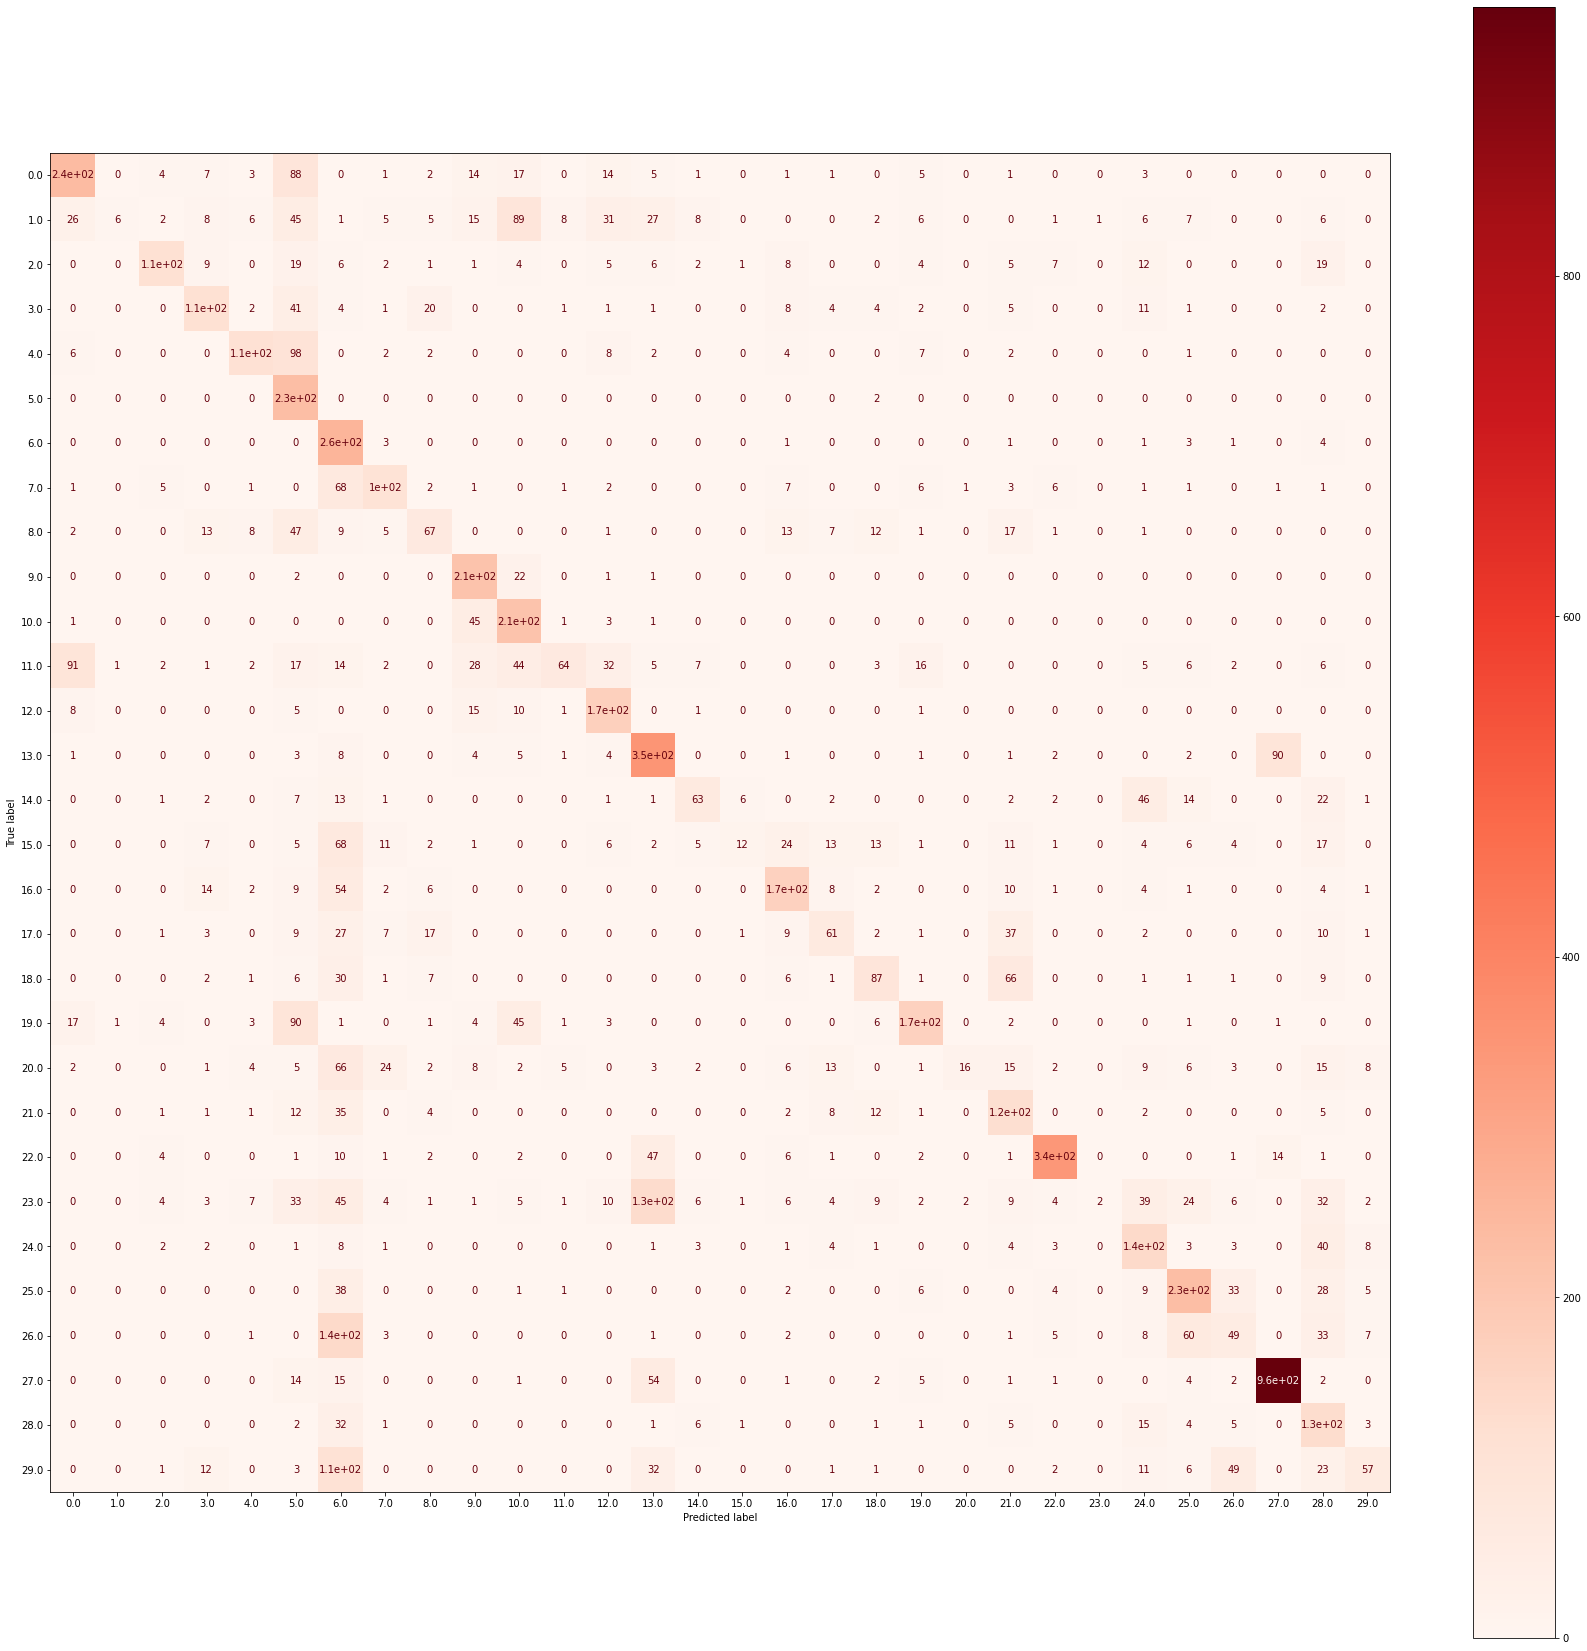

In [ ]:
label_names = np.arange(0, 30, dtype=float)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_names)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(cmap=plt.cm.Reds, ax=ax)
plt.show()

The confusion matrix shows rather interesting results: on some classes (e.g. class 6.0) the number of correctly classified instances is almost on par (or even better) wrt the CNN model but at the same time there are classes which are completely misclassified like for instance class 23.0. This is the reason why at the end the value of the metrics is pretty mediocre, the totally misclassified class are many and degrade the overall performance of the model.

For this model I wanted to use grid search with k-fold cross validation for hyperparameter tuning but due to the memory constraints again I was forced to manually try different configurations and values for the most important hyperparameters. Often the models tried suffered from overfitting but usually very low like for the configuration I chose (test 5).

<center><img src="https://imgur.com/mRRuB1K.png" width="850" 
     height="120"></center>

How does the performance of this RandomForestClassifier with DNN featurization and transfer learning compare to the performance of RandomForestClassifier without any addditional feature extraction step?


I trained a simple RandomForestClassifier with same hyperparameters of the previous random forest (*maxDepth*=3, *numTrees*=50) and I loaded the trained model here for comparison.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1MFGILxVFaAJjI8EFyQuROjnPOu0okti3
!unzip -u /content/rf_model_trained.zip -d /content

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1MFGILxVFaAJjI8EFyQuROjnPOu0okti3
To: /content/rf_model_trained.zip
100% 114k/114k [00:00<00:00, 43.6MB/s]
Archive:  /content/rf_model_trained.zip
   creating: /content/content/rf_model_trained/
   creating: /content/content/rf_model_trained/metadata/
 extracting: /content/content/rf_model_trained/metadata/._SUCCESS.crc  
  inflating: /content/content/rf_model_trained/metadata/part-00000  
 extracting: /content/content/rf_model_trained/metadata/.part-00000.crc  
 extracting: /content/content/rf_model_trained/metadata/_SUCCESS  
   creating: /content/content/rf_model_trained/treesMetadata/
 extracting: /content/content/rf_model_trained/treesMetadata/._SUCCESS.crc  
 extracting: /content/content/rf_model_trained/treesMetadata/.part-00000-8285ec00-d2ea-4abf-8eb5-6b743729390e-c000.snappy.parquet.crc  
 extracting: /content/content/rf_model_t

In [ ]:
train_df, test_df  = result.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [ ]:
simple_random_forest = RandomForestClassificationModel.load('/content/content/rf_model_trained')
predictions_df_rf = simple_random_forest.transform(test_df)

In [ ]:
evaluator_accuracy_rf = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName = 'accuracy')
evaluator_precision_rf =  MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall_rf =  MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
evaluator_f1_rf =  MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

print('Test accuracy:', evaluator_accuracy_rf.evaluate(predictions_df_rf))
print('Test precision:', evaluator_precision_rf.evaluate(predictions_df_rf))
print('Test recall:', evaluator_recall_rf.evaluate(predictions_df_rf))
print('Test f1 score:', evaluator_f1_rf.evaluate(predictions_df_rf))

Test accuracy: 0.18741450068399454
Test precision: 0.24741258596401938
Test recall: 0.18741450068399448
Test f1 score: 0.12304959677006005


As can be noticed, the performances are worse and it demonstrates how important it is in an image classification task performing a feature extraction step before training.

# **10. Application**

In addition to this notebook it was developed a simple application demo to demonstrate how the model could work in a real life use case. It was developed with Streamlit, an open-source Python library which allows to create and share web apps for machine learning and data science. The model used for the demo is the one that got the best performance, the CNN.

Check the file "docker_commands" in the folder "1758527_app" for a brief explanation of how to run the app with Docker.

Here is shown a short video that demonstrates how the app works.

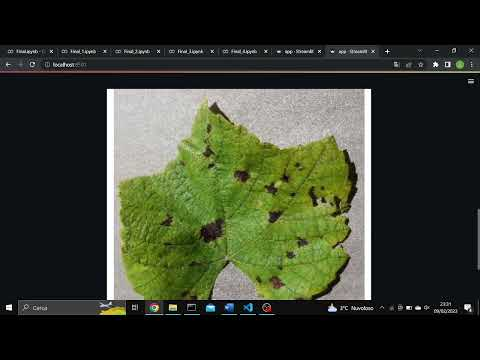

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('5vb8_oCkY-Q')

# **11. Final remarks**

As expected the model with the best performance is the Convolutional Neural Network, which is one of the most popular models in image classification tasks. Overall the performance of the random forest with DNN Featurization and transfer learning was pretty interesting since it works on very small images (32x32) and this task is very sensible to image size (the higher the image size the better the performance). It would have been extremely intriguing trying the same approach with a bigger network like AlexNet with bigger images. It also would have been interesting trying all this models with bigger images and keeping the original idea of creating a very big dataset composed by the PlantVillage dataset and my dataset. In general having more resources would have left more room for further experimentation. 